DATA WRANGLING ACS CHARACTERISTIC PROFILES

In [ ]:
IMAGE OF THE FOUR BOXES

EACH CHARACTERISTIC PROFILE PRODUCT (DEMO, HOUSING, SOCIAL, ECONOMIC) WAS RELEASED BY STATE AND CONTAINED THEIR SUBSIDIARY CONGRESSIONAL DISTRICTS. WHAT I WANT TO DO IS CREATE ONE MASSIVE DATAFRAME THAT CONTAINS EVERY CONGRESSIONAL DISTRICT AS A ^ROW^[THE DATA TERM, THOUGH] AND EVERY UNIQUE FEATURE/CHARACTERISTIC FROM THE 4 PROFILE PRODUCTS IN ONE MEGA DATAFRAME. FIRST I START WITH ONE STATE IN ONE PROFILE TO DEFINE THE FEATURE SPACE, THEN APPLY THAT TO THE OTHER 50 STATES IN THAT PROFILE, THEN MERGE THE ENTIRE PROFILE TOGETHER TO GET A DATAFRAME THAT CONTAINS EVERY DISTRICT IN THE US AND EVERY UNIQUE FEATURE WITHIN THAT PROFILE. RINSE AND REPEAT FOR THE OTHER THREE PROFILES, DELETE DATA THAT'S DUPLICATED BETWEEN PROFILES (SUCH AS TOTAL HOUSEHOLDS) AND MERGE INTO A MEGA TABLE. 

THEN I WILL MAKE A PYFILE FOR THIS PROCESS, BECAUSE WHEN THE 2022 ACS RESULTS ARE RELEASED, I CAN USE THE EXACT SAME PROCESS TO WRANGLE WITH MINIMAL EFFORT (THE CENSUS BUREAU PUBLISHES ANY CHANGES THEY MAKE BETWEEN SURVEY RELEASES HERE)

THIS WILL ALSO WORK FOR STATE LEGISLATIVE CHAMBERS IN THE SAME WAY. I WILL MAKE A PYFILE FOR ALL

THEN BEFORE I GET GET TO MY ANALYSIS, I WILL MERGE ON THE INFORMATIONS RELATED TO MY 2 TARGET ANALYSES-- PVI SCORE AND 2022 VOTER BEHAVIOR. 

In [1]:
import pandas as pd
import numpy as np
import re

In [2]:
# Set pandas display options to show up to 100 rows
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', None)

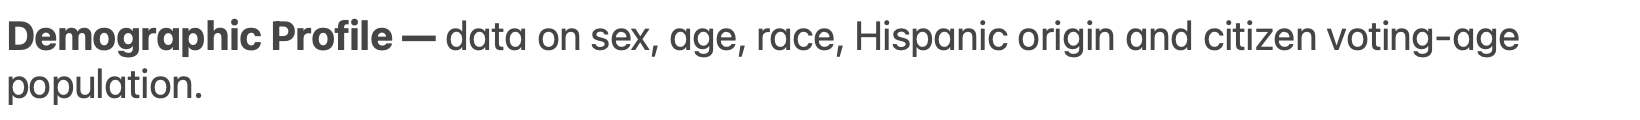

### 1. State-Level Demographic Data Transformation (Alabama)
Starting with Alabama, we'll standardize the Demographic Data Profile for analytical use. Once this approach is established, it will be replicated across the remaining states, resulting in a comprehensive demographic dataset. The same methodology will be applied for the integration of social, housing, and economic data profiles.

In [3]:
# Load in Alabama DEMOGRAPHIC file for all districts
data = pd.read_csv('data/ALLCD_DP05_AL.csv', dtype={'PROFLN': str})
data.rename(columns = {'GEONAME' :'District'}, inplace=True)

# make a dictionary of PROFLN keys to TITLE values
title_dict = dict(zip(data['PROFLN'], data['TITLE']))

# convert the dictionary to dataframe and observe 
title_df = pd.DataFrame(list(title_dict.items()), columns=['PROFLN', 'TITLE'])
title_df.head(10)

,PROFLN,TITLE
0,0,ACS DEMOGRAPHIC AND HOUSING ESTIMATES
1,0.5,NaN
2,0.8,SEX AND AGE
3,1,Total population
4,2,Male
5,3,Female
6,4,Sex ratio (males per 100 females)
7,4.3,NaN
8,5,Under 5 years
9,6,5 to 9 years


### In the above table, you can see that the PROFLN number is associated with a Title which will eventually become our columns headers.
### By combining titles we get more accurate information (i.e. index 4 will become a combination of PROFLN 1&2 to create the title "Total Population - Male"

In [4]:
title_dict

{'0': 'ACS DEMOGRAPHIC AND HOUSING ESTIMATES',
 '0.5': nan,
 '0.8': 'SEX AND AGE',
 '1': 'Total population',
 '2': 'Male',
 '3': 'Female',
 '4': 'Sex ratio (males per 100 females)',
 '4.3': nan,
 '5': 'Under 5 years',
 '6': '5 to 9 years',
 '7': '10 to 14 years',
 '8': '15 to 19 years',
 '9': '20 to 24 years',
 '10': '25 to 34 years',
 '11': '35 to 44 years',
 '12': '45 to 54 years',
 '13': '55 to 59 years',
 '14': '60 to 64 years',
 '15': '65 to 74 years',
 '16': '75 to 84 years',
 '17': '85 years and over',
 '17.3': nan,
 '18': 'Median age (years)',
 '18.3': nan,
 '19': 'Under 18 years',
 '20': '16 years and over',
 '21': '18 years and over',
 '22': '21 years and over',
 '23': '62 years and over',
 '24': '65 years and over',
 '24.3': nan,
 '25': '18 years and over',
 '26': 'Male',
 '27': 'Female',
 '28': 'Sex ratio (males per 100 females)',
 '28.3': nan,
 '29': '65 years and over',
 '30': 'Male',
 '31': 'Female',
 '32': 'Sex ratio (males per 100 females)',
 '32.3': nan,
 '32.5': 'RAC

In [5]:
## Combining PROFLN numbers which will become new TITLEs

# "Total Population-" Category
for i in range(2, 25):
    data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '1-' + str(i)

# "Total Population- 18 years and over-" Category
for i in range(25, 29):
    data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '1-25' + ('' if i == 25 else '-' + str(i))

#"Total Population- 65 years and over-" Category
for i in range(29, 33):
    data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '1-29' + ('' if i == 29 else '-' + str(i))

# "RACE-" Category
for i in range(33, 37):
    data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '32.5-' + str(i)

# "RACE- One race-" Category
for i in range(37, 58):
    data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '32.5-36-' + str(i)

# "RACE- Two or more races-" Category
for i in range(58, 63):
    data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '32.5-58' + ('' if i == 58 else '-' + str(i))

#"RACE- Race alone or in combination with one or more other races-" Category
for i in range(63, 70):
    data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '32.5-62.5-' + str(i)

# 'HISPANIC OR LATINO AND RACE-" Category
for i in range(70, 86):
    data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '69.5-' + str(i)

# 'CITIZEN, VOTING AGE POPULATION' Category
for i in range(87, 90):
    data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '86.5-' + str(i)

In [6]:
# Translate new profln numbers to combo titles
def translate_profln(profln):
    # split the PROFLN value into individual keys
    keys = profln.split('-')

    # translate each key from the title_dict
    titles = [str(title_dict.get(key, '')) for key in keys]

    # concat translated title strings
    translated_title = ' - '.join(title for title in titles if title)

    return translated_title

# replace TITLE values with their new names using function
data['TITLE'] = data['PROFLN'].apply(translate_profln)
data['TITLE'].value_counts()


TITLE
nan                                                                                                              84
RACE - Two or more races                                                                                         14
RACE - One race                                                                                                  14
Total population - 65 years and over                                                                             14
Total population - 18 years and over                                                                             14
RACE - One race - Native Hawaiian                                                                                 7
RACE - Two or more races - Black or African American and American Indian and Alaska Native                        7
RACE - One race - Other Asian                                                                                     7
RACE - Race alone or in combination with one or more other races -

In [7]:
# remove rows with NaN's, placeholder 'N' for 'Not Large Enough Sample Size', and placeholder '(X)'' rows
invalid_rows = data['PRF_ESTIMATE'].isin(['N', '(X)']) | data['PRF_ESTIMATE'].isna()

# filter out these rows from the Dataframe
data = data[~invalid_rows]



In [8]:
# remove rows of duplicate information or strong overlap

# List of PROFLN values to remove (many values are repeats from other categories and subcategories)
profln_to_remove = ['1-29', '1-25', '32.5-33', '32.5-36', '32.5-58', 
                    '32.5-62.5-63', '32.5-62.5-64', '32.5-62.5-65', 
                    '32.5-62.5-66', '32.5-62.5-67', '32.5-62.5-68', 
                    '32.5-62.5-69', '69.5-70', '69.5-76', '69.5-77', 
                    '69.5-78', '69.5-79', '69.5-80', '69.5-81', '69.5-82']

# filter the data to observe which rows we are removing
rows_to_remove = data[data['PROFLN'].isin(profln_to_remove)]
print(rows_to_remove['TITLE'])

# Remove these rows from the DataFrame
data = data[~data['PROFLN'].isin(profln_to_remove)]

31                                               Total population - 18 years and over
36                                               Total population - 65 years and over
42                                                            RACE - Total population
46                                                                    RACE - One race
68                                                           RACE - Two or more races
                                            ...                                      
734                     HISPANIC OR LATINO AND RACE - Black or African American alone
735             HISPANIC OR LATINO AND RACE - American Indian and Alaska Native alone
736                                         HISPANIC OR LATINO AND RACE - Asian alone
737    HISPANIC OR LATINO AND RACE - Native Hawaiian and Other Pacific Islander alone
738                               HISPANIC OR LATINO AND RACE - Some other race alone
Name: TITLE, Length: 138, dtype: object


In [9]:
# Delete margin of error columns
data = data.drop(columns=['PRF_MG_ERROR', 'PCT_MG_ERROR'])

# Some MEDIAN and MEAN values are not listed in PCT_ESTIMATE column, but are relevant
data.loc[data['PCT_ESTIMATE'] == '(X)', 'PCT_ESTIMATE'] = data['PRF_ESTIMATE']

# Convert all the values to numeric
data['PCT_ESTIMATE'] = data['PCT_ESTIMATE'].str.replace(',', '').astype(float)
data['PRF_ESTIMATE'] = data['PRF_ESTIMATE'].str.replace(',', '').astype(float)

data

,TBLID,GEOID,District,PROFLN,TITLE,PRF_ESTIMATE,PCT_ESTIMATE
3,DP05,5001800US0101,"Congressional District 1 (118th Congress), Alabama",1,Total population,727212.0,727212.0
4,DP05,5001800US0101,"Congressional District 1 (118th Congress), Alabama",1-2,Total population - Male,353457.0,48.6
5,DP05,5001800US0101,"Congressional District 1 (118th Congress), Alabama",1-3,Total population - Female,373755.0,51.4
6,DP05,5001800US0101,"Congressional District 1 (118th Congress), Alabama",1-4,Total population - Sex ratio (males per 100 females),94.6,94.6
8,DP05,5001800US0101,"Congressional District 1 (118th Congress), Alabama",1-5,Total population - Under 5 years,41746.0,5.7
...,...,...,...,...,...,...,...
741,DP05,5001800US0107,"Congressional District 7 (118th Congress), Alabama",69.5-85,"HISPANIC OR LATINO AND RACE - Two races excluding Some other race, and Three or more races",14020.0,2.0
743,DP05,5001800US0107,"Congressional District 7 (118th Congress), Alabama",86,Total housing units,344719.0,344719.0
746,DP05,5001800US0107,"Congressional District 7 (118th Congress), Alabama",86.5-87,"CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population",546972.0,546972.0
747,DP05,5001800US0107,"Congressional District 7 (118th Congress), Alabama",86.5-88,"CITIZEN, VOTING AGE POPULATION - Male",252332.0,46.1


In [10]:
## Converting the long district titles to their state and district codes ('AL-01' = 'Alabama District 1')
# State Mapping
states = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA',
    'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA',
    'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS',
    'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH',
    'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC',
    'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA',
    'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD', 'Tennessee': 'TN',
    'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA',
    'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'
}

def format_district(district):
    # Extract the state name and district number from the district string
    match = re.search(r'Congressional District (\d+|\(at Large\)) \(118th Congress\), ([A-Za-z\s]+)', district)
    if match:
        district_num, state_name = match.groups()
        # Convert the district number to 'AL' for 'at large' districts
        if district_num == '(at Large)':
            district_num = 'AL'
        else:
            district_num = district_num.zfill(2)  # Pad single digit numbers with a leading zero
        # Convert state name to its abbreviation
        state_abbr = states.get(state_name.strip(), state_name)
        # Return the formatted district name
        return f'{state_abbr}-{district_num}'
    
# Apply the function to the 'District' column in both dataframes to replace values with their short-hand
data['Formatted_District'] = data['District'].apply(format_district)



In [11]:
#ensure all districts have the same number of values
data['Formatted_District'].value_counts()


Formatted_District
AL-01    61
AL-02    61
AL-03    61
AL-04    61
AL-05    61
AL-06    61
AL-07    61
Name: count, dtype: int64

In [12]:
# Pivot the dataframe separately into two dataframes with 'PRF_ESTIMATE' (raw numbers) and 'PCT_ESTIMATE' (%'s)
prf_estimate_df = data.pivot_table(index=['Formatted_District', 'GEOID'], columns='TITLE', values='PRF_ESTIMATE')
pct_estimate_df = data.pivot_table(index=['Formatted_District', 'GEOID'], columns='TITLE', values='PCT_ESTIMATE')

# Reset the column names after pivot
prf_estimate_df.columns = [f'{col}' for col in prf_estimate_df.columns]
pct_estimate_df.columns = [f'{col}' for col in pct_estimate_df.columns]

# Reset the index
prf_estimate_df.reset_index(inplace=True)
pct_estimate_df.reset_index(inplace=True)

prf_estimate_df

,Formatted_District,GEOID,"CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population","CITIZEN, VOTING AGE POPULATION - Female","CITIZEN, VOTING AGE POPULATION - Male",HISPANIC OR LATINO AND RACE - Cuban,HISPANIC OR LATINO AND RACE - Hispanic or Latino (of any race),HISPANIC OR LATINO AND RACE - Mexican,HISPANIC OR LATINO AND RACE - Other Hispanic or Latino,HISPANIC OR LATINO AND RACE - Puerto Rican,...,Total population - 65 years and over - Male,Total population - 65 years and over - Sex ratio (males per 100 females),Total population - 75 to 84 years,Total population - 85 years and over,Total population - Female,Total population - Male,Total population - Median age (years),Total population - Sex ratio (males per 100 females),Total population - Under 18 years,Total population - Under 5 years
0,AL-01,5001800US0101,555123.0,289663.0,265460.0,1480.0,25346.0,14082.0,6571.0,3213.0,...,61808.0,82.8,40508.0,12282.0,373755.0,353457.0,41.0,94.6,162658.0,41746.0
1,AL-02,5001800US0102,539010.0,284652.0,254358.0,479.0,29072.0,18554.0,5484.0,4555.0,...,54456.0,76.9,38134.0,12806.0,370483.0,345729.0,39.0,93.3,165222.0,41997.0
2,AL-03,5001800US0103,558552.0,289423.0,269129.0,766.0,22960.0,11728.0,6468.0,3998.0,...,55915.0,79.6,39234.0,8784.0,368853.0,352436.0,40.0,95.5,152113.0,39510.0
3,AL-04,5001800US0104,541258.0,280884.0,260374.0,1322.0,52766.0,37454.0,11988.0,2002.0,...,59392.0,79.6,40315.0,12003.0,369637.0,353433.0,40.5,95.6,165303.0,45914.0
4,AL-05,5001800US0105,557827.0,285421.0,272406.0,1481.0,41789.0,20557.0,13835.0,5916.0,...,54646.0,78.2,37413.0,12440.0,370374.0,359010.0,40.5,96.9,157595.0,37683.0
5,AL-06,5001800US0106,531046.0,277760.0,253286.0,1180.0,36253.0,24216.0,9624.0,1233.0,...,52246.0,79.7,35741.0,11321.0,363521.0,342976.0,39.6,94.3,161580.0,41408.0
6,AL-07,5001800US0107,546972.0,294640.0,252332.0,1024.0,29248.0,18521.0,8699.0,1004.0,...,50770.0,71.7,32485.0,12120.0,377358.0,338855.0,37.5,89.8,155471.0,41833.0


# 1.b - DEMOGRAPHICS Data -- (converting previous steps into functions to apply and join all 50 state files)

In [13]:
#LOAD FUNCTION

def load_and_rename_data(csv):
    data = pd.read_csv(csv, dtype={'PROFLN': str})
    data.rename(columns = {'GEONAME' :'District'}, inplace=True)
    return data

In [14]:
## translate PROFLN number into associated title
def translate_profln(profln, title_dict):
    # split the PROFLN value into keys by '-' for multi-labeled categories
    keys = profln.split('-')
    # translate each key using the title_dict
    titles = [str(title_dict.get(key, '')) for key in keys]
    # concatenate the translated titles
    translated_title = ' - '.join(title for title in titles if title)

    return translated_title

def translate_profln(profln, title_dict):
    # split the PROFLN value into keys by '-' for multi-labeled categories
    keys = profln.split('-')
    # translate each key using the title_dict
    titles = [str(title_dict.get(key, key)) for key in keys]
    # join the translated titles with ', '
    return ', '.join(titles)


In [15]:
def update_titles_demo(data):
    # Create the title_dict
    title_dict = dict(zip(data['PROFLN'], data['TITLE']))
    # Update PROFLN values
    for i in range(2, 25):
        data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '1-' + str(i)
    for i in range(25, 29):
        data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '1-25' + ('' if i == 25 else '-' + str(i))
    for i in range(29, 33):
        data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '1-29' + ('' if i == 29 else '-' + str(i))
    for i in range(33, 37):
        data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '32.5-' + str(i)
    for i in range(37, 58):
        data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '32.5-36-' + str(i)
    for i in range(58, 63):
        data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '32.5-58' + ('' if i == 58 else '-' + str(i))
    for i in range(63, 70):
        data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '32.5-62.5-' + str(i)
    for i in range(70, 86):
        data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '69.5-' + str(i)
    for i in range(87, 90):
        data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '86.5-' + str(i)

    # Update TITLE values
    data['TITLE'] = data['PROFLN'].apply(lambda x: translate_profln(x, title_dict)) #using translate_profln function

    return data


#UPDATE PROFLN FUNCTION

def update_profln_values_demo(data):
    for i in range(2, 25):
        data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '1-' + str(i)
    for i in range(25, 29):
        data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '1-25' + ('' if i == 25 else '-' + str(i))
    for i in range(29, 33):
        data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '1-29' + ('' if i == 29 else '-' + str(i))
    for i in range(33, 37):
        data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '32.5-' + str(i)
    for i in range(37, 58):
        data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '32.5-36-' + str(i)
    for i in range(58, 63):
        data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '32.5-58' + ('' if i == 58 else '-' + str(i))
    for i in range(63, 70):
        data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '32.5-62.5-' + str(i)
    for i in range(70, 86):
        data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '69.5-' + str(i)
    for i in range(87, 90):
        data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '86.5-' + str(i)
    return data

In [16]:
# CLEAN UP DATA AND DROP REDUNDANT INFO FUNCTION

def clean_up_data_demo(data):
    # drop unneccessary rows and rows with placeholders
    invalid_rows = data['PRF_ESTIMATE'].isin(['N', '(X)']) | data['PRF_ESTIMATE'].isna()
    data = data[~invalid_rows]

    # The rows associated with these index markers (profln) contain duplicated data
    profln_to_remove = ['1-29', '1-25', '32.5-33', '32.5-36', '32.5-58', 
                        '32.5-62.5-63', '32.5-62.5-64', '32.5-62.5-65', 
                        '32.5-62.5-66', '32.5-62.5-67', '32.5-62.5-68', 
                        '32.5-62.5-69', '69.5-70', '69.5-76', '69.5-77', 
                        '69.5-78', '69.5-79', '69.5-80', '69.5-81', '69.5-82']
    data = data[~data['PROFLN'].isin(profln_to_remove)]

    # Delete the margin of error columns
    data = data.drop(columns=['PRF_MG_ERROR', 'PCT_MG_ERROR'])

    # Replace '(X)' values in PCT_ESTIMATE with their PRF_ESTIMATE values (usually, average and median values)
    data.loc[data['PCT_ESTIMATE'] == '(X)', 'PCT_ESTIMATE'] = data['PRF_ESTIMATE']

    # convert to numeric
    data['PCT_ESTIMATE'] = data['PCT_ESTIMATE'].str.replace(',', '').astype(float)
    data['PRF_ESTIMATE'] = data['PRF_ESTIMATE'].str.replace(',', '').astype(float)
    
    return data


In [17]:
# SHORTHAND STATE-DISTRICT FUNCTION

def format_districts(data):
    # dictionary of state names to abbreviations
    states = {
        'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
        'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA',
        'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA',
        'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
        'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS',
        'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH',
        'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC',
        'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA',
        'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD', 'Tennessee': 'TN',
        'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA',
        'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'
    }

    # function to format a single district
    def format_district(district):
        # extract the state name and district number from the district string
        match = re.search(r'Congressional District (\d+|\(at Large\)) \(118th Congress\), ([A-Za-z\s]+)', district)
        if match:
            district_num, state_name = match.groups()
            # convert the district number to 'AL' for 'at large' districts
            if district_num == '(at Large)':
                district_num = 'AL'
            else:
                district_num = district_num.zfill(2)  # pad single digit numbers with a leading zero
            # convert the state name to its abbreviation
            state_abbr = states.get(state_name.strip(), state_name)
            # return the formatted district name
            return f'{state_abbr}-{district_num}'
        else:
            return district

    # Apply the function to the District column
    data['Formatted_District'] = data['District'].apply(format_district)

    return data


In [18]:
## TRANSPOSE DATAFRAME FUNCTION
def reorient_dfs(data):
    # Pivot the dataframe separately for 'PRF_ESTIMATE' and 'PCT_ESTIMATE'
    prf_estimate_df = data.pivot_table(index=['Formatted_District', 'GEOID'], columns='TITLE', values='PRF_ESTIMATE')
    pct_estimate_df = data.pivot_table(index=['Formatted_District', 'GEOID'], columns='TITLE', values='PCT_ESTIMATE')

    # Reset the column names after pivot
    prf_estimate_df.columns = [f'{col}' for col in prf_estimate_df.columns]
    pct_estimate_df.columns = [f'{col}' for col in pct_estimate_df.columns]

    # Reset the index
    prf_estimate_df.reset_index(inplace=True)
    pct_estimate_df.reset_index(inplace=True)

    return prf_estimate_df, pct_estimate_df


# 1.c - DEMOGRAPHIC Data -- (process all 50 states demographic files)

In [19]:
## PROCESS ALL 50 STATES FUNCTION
def process_demographics(file_state_list):
    prf_dfs = []
    pct_dfs = []
    
    for file_state in file_state_list:
        csv, state = file_state

        data = load_and_rename_data(csv)
        data = update_titles_demo(data)
        data = clean_up_data_demo(data)
        data = format_districts(data)

        prf_estimate_df, pct_estimate_df = reorient_dfs(data)

        prf_dfs.append(prf_estimate_df)
        pct_dfs.append(pct_estimate_df)
    
    df_prfdemo_all = pd.concat(prf_dfs, ignore_index=True)
    df_pctdemo_all = pd.concat(pct_dfs, ignore_index=True)
    
    return df_prfdemo_all, df_pctdemo_all


In [20]:
file_state_list = [
 ('data/ALLCD_DP05_AK.csv', 'AK'),('data/ALLCD_DP05_AL.csv', 'AL'),('data/ALLCD_DP05_AR.csv', 'AR'),
 ('data/ALLCD_DP05_AZ.csv', 'AZ'),('data/ALLCD_DP05_CA.csv', 'CA'),('data/ALLCD_DP05_CO.csv', 'CO'),
 ('data/ALLCD_DP05_CT.csv', 'CT'),('data/ALLCD_DP05_DE.csv', 'DE'),('data/ALLCD_DP05_FL.csv', 'FL'),
 ('data/ALLCD_DP05_GA.csv', 'GA'),('data/ALLCD_DP05_HI.csv', 'HI'),('data/ALLCD_DP05_IA.csv', 'IA'),
 ('data/ALLCD_DP05_ID.csv', 'ID'),('data/ALLCD_DP05_IL.csv', 'IL'),('data/ALLCD_DP05_IN.csv', 'IN'),
 ('data/ALLCD_DP05_KS.csv', 'KS'),('data/ALLCD_DP05_KY.csv', 'KY'),('data/ALLCD_DP05_LA.csv', 'LA'),
 ('data/ALLCD_DP05_MA.csv', 'MA'),('data/ALLCD_DP05_MD.csv', 'MD'),('data/ALLCD_DP05_ME.csv', 'ME'),
 ('data/ALLCD_DP05_MI.csv', 'MI'),('data/ALLCD_DP05_MN.csv', 'MN'),('data/ALLCD_DP05_MO.csv', 'MO'),
 ('data/ALLCD_DP05_MS.csv', 'MS'),('data/ALLCD_DP05_MT.csv', 'MT'),('data/ALLCD_DP05_NC.csv', 'NC'),
 ('data/ALLCD_DP05_ND.csv', 'ND'),('data/ALLCD_DP05_NE.csv', 'NE'),('data/ALLCD_DP05_NH.csv', 'NH'),
 ('data/ALLCD_DP05_NJ.csv', 'NJ'),('data/ALLCD_DP05_NM.csv', 'NM'),('data/ALLCD_DP05_NV.csv', 'NV'),
 ('data/ALLCD_DP05_NY.csv', 'NY'),('data/ALLCD_DP05_OH.csv', 'OH'),('data/ALLCD_DP05_OK.csv', 'OK'),
 ('data/ALLCD_DP05_OR.csv', 'OR'),('data/ALLCD_DP05_PA.csv', 'PA'),('data/ALLCD_DP05_RI.csv', 'RI'),
 ('data/ALLCD_DP05_SC.csv', 'SC'),('data/ALLCD_DP05_SD.csv', 'SD'),('data/ALLCD_DP05_TN.csv', 'TN'),
 ('data/ALLCD_DP05_TX.csv', 'TX'),('data/ALLCD_DP05_UT.csv', 'UT'),('data/ALLCD_DP05_VA.csv', 'VA'),
 ('data/ALLCD_DP05_VT.csv', 'VT'),('data/ALLCD_DP05_WA.csv', 'WA'),('data/ALLCD_DP05_WI.csv', 'WI'),
 ('data/ALLCD_DP05_WV.csv', 'WV'),('data/ALLCD_DP05_WY.csv', 'WY')
]


df_prfdemo_all, df_pctdemo_all = process_demographics(file_state_list)


In [21]:
df_prfdemo_all

,Formatted_District,GEOID,"CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population","CITIZEN, VOTING AGE POPULATION - Female","CITIZEN, VOTING AGE POPULATION - Male",HISPANIC OR LATINO AND RACE - Cuban,HISPANIC OR LATINO AND RACE - Hispanic or Latino (of any race),HISPANIC OR LATINO AND RACE - Mexican,HISPANIC OR LATINO AND RACE - Other Hispanic or Latino,HISPANIC OR LATINO AND RACE - Puerto Rican,...,Total population - 65 years and over - Male,Total population - 65 years and over - Sex ratio (males per 100 females),Total population - 75 to 84 years,Total population - 85 years and over,Total population - Female,Total population - Male,Total population - Median age (years),Total population - Sex ratio (males per 100 females),Total population - Under 18 years,Total population - Under 5 years
0,AK-AL,5001800US0200,533852.0,252485.0,281367.0,3182.0,52291.0,22299.0,18157.0,8653.0,...,49676.0,101.9,24410.0,6709.0,349552.0,383121.0,35.6,109.6,179401.0,46198.0
1,AL-01,5001800US0101,555123.0,289663.0,265460.0,1480.0,25346.0,14082.0,6571.0,3213.0,...,61808.0,82.8,40508.0,12282.0,373755.0,353457.0,41.0,94.6,162658.0,41746.0
2,AL-02,5001800US0102,539010.0,284652.0,254358.0,479.0,29072.0,18554.0,5484.0,4555.0,...,54456.0,76.9,38134.0,12806.0,370483.0,345729.0,39.0,93.3,165222.0,41997.0
3,AL-03,5001800US0103,558552.0,289423.0,269129.0,766.0,22960.0,11728.0,6468.0,3998.0,...,55915.0,79.6,39234.0,8784.0,368853.0,352436.0,40.0,95.5,152113.0,39510.0
4,AL-04,5001800US0104,541258.0,280884.0,260374.0,1322.0,52766.0,37454.0,11988.0,2002.0,...,59392.0,79.6,40315.0,12003.0,369637.0,353433.0,40.5,95.6,165303.0,45914.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,WI-07,5001800US5507,579658.0,284696.0,294962.0,675.0,19067.0,11203.0,5014.0,2175.0,...,77436.0,93.4,45479.0,17297.0,365784.0,378859.0,44.9,103.6,157839.0,36524.0
431,WI-08,5001800US5508,562233.0,281545.0,280688.0,548.0,44334.0,29112.0,7778.0,6896.0,...,62612.0,87.9,38348.0,14223.0,365825.0,371023.0,41.1,101.4,162548.0,40347.0
432,WV-01,5001800US5401,696591.0,357316.0,339275.0,404.0,9502.0,3745.0,3927.0,1426.0,...,88221.0,83.6,55153.0,19269.0,447881.0,434099.0,44.0,96.9,180487.0,43443.0
433,WV-02,5001800US5402,712176.0,356501.0,355675.0,491.0,20848.0,7160.0,9278.0,3919.0,...,81831.0,87.8,51215.0,16552.0,447718.0,453261.0,41.6,101.2,180905.0,45341.0


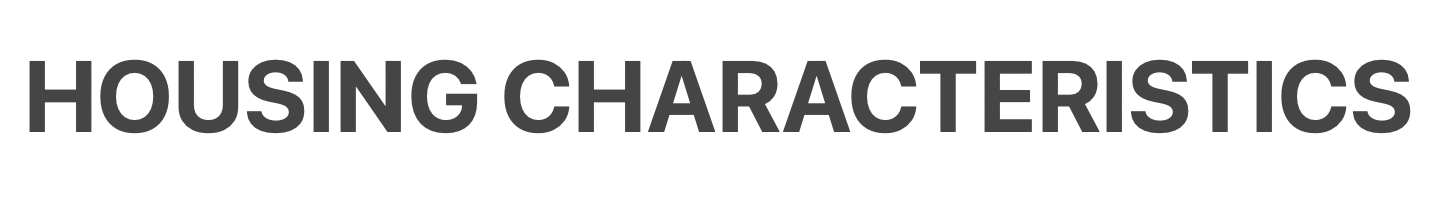

# 2.a - HOUSING Data -- (cleaning and converting individual state file into usable data)

In [22]:
## LOAD_AND_RENAME_DATA FUNCTION REMAINS THE SAME
AL_housing_df = load_and_rename_data('data/ALLCD_DP04_AL.csv')

In [23]:
#Profln values and their corresponding TITLE/associations have changed. Revamping title formatting
def update_titles_housing(data):
    # Create the title_dict
    title_dict = dict(zip(data['PROFLN'], data['TITLE']))
    
    #Update PROFLN numbers by category
    for i in range(1, 6): 
        data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '0.8-' + str(i) # "HOUSING OCCUPANCY-" Category
    for i in range(6, 16): 
        data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '5.5-' + str(i) # "UNITS IN STRUCTURE-" Category
    for i in range(16, 27): 
        data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '15.5-' + str(i) # "YEAR STRUCTURE BUILT-" Category
    for i in range(27, 38): 
        data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '26.5-' + str(i) # "ROOMS-" Category
    for i in range(39, 45): 
        data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '37.5-' + str(i) # "BEDROOMS-" Category
    for i in range(45, 57): 
        data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '44.5-' + str(i) # "HOUSING TENURE-" Category
    for i in range(57, 62): 
        data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '56.5-' + str(i) # "VEHICLES AVAILABLE-" Category
    for i in range(62, 72): 
        data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '61.5-' + str(i) # "HOUSE HEATING FUEL-" Category
    for i in range(72, 76): 
        data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '71.5-' + str(i) # "SELECTED CHARACTERISTICS-" Category
    for i in range(76, 80): 
        data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '75.5-' + str(i) # "OCCUPANTS PER ROOM-" Category
    for i in range(80, 90): 
        data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '79.5-' + str(i)  # "VALUE-" Category
    for i in range(90, 93): 
        data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '89.5-' + str(i)   # "MORTGAGE STATUS-" Category
    for i in range(126, 136):
        data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '125.5-' + str(i) # "GROSS RENT-" Category
        
    ###LONG TITLES BELOW###
    
    # "SELECTED MONTHLY OWNER COSTS (SMOC)- Housing units with a mortgage- " Category
    for i in range(93, 102):
        data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '92.5-93' + ('' if i == 93 else '-' + str(i))
    # "SELECTED MONTHLY OWNER COSTS (SMOC)- Housing units without a mortgage- " Category
    for i in range(102, 110):
        data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '92.5-102' + ('' if i == 102 else '-' + str(i))  
    # "SELECTED MONTHLY OWNER COSTS AS A PERCENTAGE OF HOUSEHOLD INCOME (SMOCAPI)- 
    # Housing units with a mortgage (excluding units where SMOCAPI cannot be computed)-" Category
    for i in range(110, 116):
        data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '109.5-110' + ('' if i == 110 else '-' + str(i))  
    # "SELECTED MONTHLY OWNER COSTS AS A PERCENTAGE OF HOUSEHOLD INCOME (SMOCAPI)-
    # Housing unit without a mortgage (excluding units where SMOCAPI cannot be computed)-" Category
    for i in range(117, 125):
        data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '109.5-117' + ('' if i == 117 else '-' + str(i))
    #"GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME (GRAPI)-" Category
    for i in range(136, 143):
        data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '135.5-' + str(i)
        
    # Translate TITLE values using previously defined 'translate_profln' function
    data['TITLE'] = data['PROFLN'].apply(lambda x: translate_profln(x, title_dict))

    return data

In [24]:
AL_housing_df = update_titles_housing(AL_housing_df)

In [25]:
AL_housing_df.to_csv('alabamahousing.csv')

In [26]:
# CLEAN UP DATA AND DROP REDUNDANT INFO FROM HOUSING DATASET FUNCTION

def clean_up_data_housing(data):
    # drop unneccessary rows and rows with placeholders
    invalid_rows = data['PRF_ESTIMATE'].isin(['N', '(X)']) | data['PRF_ESTIMATE'].isna()
    data = data[~invalid_rows]

    # Drop rows where 'TITLE' contains 'Not computed'
    data = data[~data['TITLE'].str.contains('Not computed', na=False)]

    # The rows associated with these (profln) contain duplicated data
    profln_to_remove = ['5.5-6','15.5-16', '26.5-27', '38',                        # Duplicated Total Housing Units
                        '44.5-45','44.5-50', '56.5-57', '61.5-62','71.5-72', '75.5-76', #Dup. Occupied HU
                        '79.5-80', '89.5-90', '92.5-93','109.5-110','92.5-102', '109.5-117', #Mortgage/No Mortgage
                        '135.5-136']                                                       #Dup. HU Renting
    
    data = data[~data['PROFLN'].isin(profln_to_remove)]

    # Delete the margin of error columns
    data = data.drop(columns=['PRF_MG_ERROR', 'PCT_MG_ERROR'])

    # Replace '(X)' values in PCT_ESTIMATE with their PRF_ESTIMATE values (usually average and median values)
    data.loc[data['PCT_ESTIMATE'] == '(X)', 'PCT_ESTIMATE'] = data['PRF_ESTIMATE']

    # Remove '+' and ',' from 'PCT_ESTIMATE' and 'PRF_ESTIMATE', then convert to float
    for col in ['PCT_ESTIMATE', 'PRF_ESTIMATE']:
        data[col] = data[col].str.replace(',', '').str.replace('+', '').astype(float)
    
    return data



In [27]:
AL_housing_df = clean_up_data_housing(AL_housing_df)

In [28]:
format_districts(AL_housing_df)

,TBLID,GEOID,District,PROFLN,TITLE,PRF_ESTIMATE,PCT_ESTIMATE,Formatted_District
3,DP04,5001800US0101,"Congressional District 1 (118th Congress), Alabama",0.8-1,HOUSING OCCUPANCY - Total housing units,349120.0,349120.0,AL-01
4,DP04,5001800US0101,"Congressional District 1 (118th Congress), Alabama",0.8-2,HOUSING OCCUPANCY - Occupied housing units,284318.0,81.4,AL-01
5,DP04,5001800US0101,"Congressional District 1 (118th Congress), Alabama",0.8-3,HOUSING OCCUPANCY - Vacant housing units,64802.0,18.6,AL-01
7,DP04,5001800US0101,"Congressional District 1 (118th Congress), Alabama",0.8-4,HOUSING OCCUPANCY - Homeowner vacancy rate,1.2,1.2,AL-01
8,DP04,5001800US0101,"Congressional District 1 (118th Congress), Alabama",0.8-5,HOUSING OCCUPANCY - Rental vacancy rate,13.5,13.5,AL-01
...,...,...,...,...,...,...,...,...
1295,DP04,5001800US0107,"Congressional District 7 (118th Congress), Alabama",135.5-138,GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME (GRAPI) - 15.0 to 19.9 percent,11550.0,11.7,AL-07
1296,DP04,5001800US0107,"Congressional District 7 (118th Congress), Alabama",135.5-139,GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME (GRAPI) - 20.0 to 24.9 percent,10283.0,10.5,AL-07
1297,DP04,5001800US0107,"Congressional District 7 (118th Congress), Alabama",135.5-140,GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME (GRAPI) - 25.0 to 29.9 percent,8622.0,8.8,AL-07
1298,DP04,5001800US0107,"Congressional District 7 (118th Congress), Alabama",135.5-141,GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME (GRAPI) - 30.0 to 34.9 percent,9195.0,9.3,AL-07


In [29]:
AL_housing_prf, AL_housing_pct = reorient_dfs(AL_housing_df)

In [30]:
AL_housing_pct

,Formatted_District,GEOID,BEDROOMS - 1 bedroom,BEDROOMS - 2 bedrooms,BEDROOMS - 3 bedrooms,BEDROOMS - 4 bedrooms,BEDROOMS - 5 or more bedrooms,BEDROOMS - No bedroom,"GROSS RENT - $1,000 to $1,499","GROSS RENT - $1,500 to $1,999",...,YEAR STRUCTURE BUILT - Built 1939 or earlier,YEAR STRUCTURE BUILT - Built 1940 to 1949,YEAR STRUCTURE BUILT - Built 1950 to 1959,YEAR STRUCTURE BUILT - Built 1960 to 1969,YEAR STRUCTURE BUILT - Built 1970 to 1979,YEAR STRUCTURE BUILT - Built 1980 to 1989,YEAR STRUCTURE BUILT - Built 1990 to 1999,YEAR STRUCTURE BUILT - Built 2000 to 2009,YEAR STRUCTURE BUILT - Built 2010 to 2019,YEAR STRUCTURE BUILT - Built 2020 or later
0,AL-01,5001800US0101,6.4,21.6,49.9,17.8,3.0,1.5,35.0,5.3,...,2.9,3.0,6.2,10.0,16.5,13.4,16.4,20.1,10.7,0.8
1,AL-02,5001800US0102,5.3,20.5,51.4,18.4,3.4,1.1,25.0,4.4,...,4.1,2.6,7.3,10.5,17.1,13.8,16.7,15.6,11.4,0.9
2,AL-03,5001800US0103,5.2,24.9,48.4,16.9,3.6,1.0,20.2,5.1,...,4.7,4.1,6.9,8.9,14.0,14.5,16.2,16.5,13.2,1.0
3,AL-04,5001800US0104,4.7,23.0,52.6,14.9,3.3,1.6,11.9,1.9,...,5.2,4.4,8.6,11.2,15.9,13.6,16.9,13.7,9.6,0.8
4,AL-05,5001800US0105,6.2,19.0,46.8,21.7,5.1,1.2,28.1,8.8,...,3.3,2.3,5.6,12.8,13.2,13.2,14.2,19.7,14.9,0.8
5,AL-06,5001800US0106,5.3,19.8,46.8,20.2,6.9,1.0,40.0,13.9,...,4.1,3.5,6.6,8.9,16.1,14.7,17.4,18.0,10.2,0.6
6,AL-07,5001800US0107,8.6,25.1,48.3,13.5,2.9,1.6,22.9,6.4,...,8.3,6.0,13.1,12.5,16.4,12.0,10.5,11.2,9.4,0.4


# 2.a - HOUSING Data -- (cleaning and applying housing data to all 50 states)

In [31]:
## PROCESS ALL 50 STATES HOUSING FUNCTION
def process_housing(file_state_list):
    prf_dfs = []
    pct_dfs = []
    
    for file_state in file_state_list:
        csv, state = file_state

        data = load_and_rename_data(csv)
        data = update_titles_housing(data)
        data = clean_up_data_housing(data)
        data = format_districts(data)

        prf_estimate_df, pct_estimate_df = reorient_dfs(data)

        prf_dfs.append(prf_estimate_df)
        pct_dfs.append(pct_estimate_df)
    
    df_prfhousing_all = pd.concat(prf_dfs, ignore_index=True)
    df_pcthousing_all = pd.concat(pct_dfs, ignore_index=True)
    
    return df_prfhousing_all, df_pcthousing_all


In [32]:
file_state_list = [
 ('data/ALLCD_DP04_AK.csv', 'AK'),('data/ALLCD_DP04_AL.csv', 'AL'),('data/ALLCD_DP04_AR.csv', 'AR'),
 ('data/ALLCD_DP04_AZ.csv', 'AZ'),('data/ALLCD_DP04_CA.csv', 'CA'),('data/ALLCD_DP04_CO.csv', 'CO'),
 ('data/ALLCD_DP04_CT.csv', 'CT'),('data/ALLCD_DP04_DE.csv', 'DE'),('data/ALLCD_DP04_FL.csv', 'FL'),
 ('data/ALLCD_DP04_GA.csv', 'GA'),('data/ALLCD_DP04_HI.csv', 'HI'),('data/ALLCD_DP04_IA.csv', 'IA'),
 ('data/ALLCD_DP04_ID.csv', 'ID'),('data/ALLCD_DP04_IL.csv', 'IL'),('data/ALLCD_DP04_IN.csv', 'IN'),
 ('data/ALLCD_DP04_KS.csv', 'KS'),('data/ALLCD_DP04_KY.csv', 'KY'),('data/ALLCD_DP04_LA.csv', 'LA'),
 ('data/ALLCD_DP04_MA.csv', 'MA'),('data/ALLCD_DP04_MD.csv', 'MD'),('data/ALLCD_DP04_ME.csv', 'ME'),
 ('data/ALLCD_DP04_MI.csv', 'MI'),('data/ALLCD_DP04_MN.csv', 'MN'),('data/ALLCD_DP04_MO.csv', 'MO'),
 ('data/ALLCD_DP04_MS.csv', 'MS'),('data/ALLCD_DP04_MT.csv', 'MT'),('data/ALLCD_DP04_NC.csv', 'NC'),
 ('data/ALLCD_DP04_ND.csv', 'ND'),('data/ALLCD_DP04_NE.csv', 'NE'),('data/ALLCD_DP04_NH.csv', 'NH'),
 ('data/ALLCD_DP04_NJ.csv', 'NJ'),('data/ALLCD_DP04_NM.csv', 'NM'),('data/ALLCD_DP04_NV.csv', 'NV'),
 ('data/ALLCD_DP04_NY.csv', 'NY'),('data/ALLCD_DP04_OH.csv', 'OH'),('data/ALLCD_DP04_OK.csv', 'OK'),
 ('data/ALLCD_DP04_OR.csv', 'OR'),('data/ALLCD_DP04_PA.csv', 'PA'),('data/ALLCD_DP04_RI.csv', 'RI'),
 ('data/ALLCD_DP04_SC.csv', 'SC'),('data/ALLCD_DP04_SD.csv', 'SD'),('data/ALLCD_DP04_TN.csv', 'TN'),
 ('data/ALLCD_DP04_TX.csv', 'TX'),('data/ALLCD_DP04_UT.csv', 'UT'),('data/ALLCD_DP04_VA.csv', 'VA'),
 ('data/ALLCD_DP04_VT.csv', 'VT'),('data/ALLCD_DP04_WA.csv', 'WA'),('data/ALLCD_DP04_WI.csv', 'WI'),
 ('data/ALLCD_DP04_WV.csv', 'WV'),('data/ALLCD_DP04_WY.csv', 'WY')
]


df_prfhousing_all, df_pcthousing_all = process_housing(file_state_list)


In [33]:
df_prfhousing_all

,Formatted_District,GEOID,BEDROOMS - 1 bedroom,BEDROOMS - 2 bedrooms,BEDROOMS - 3 bedrooms,BEDROOMS - 4 bedrooms,BEDROOMS - 5 or more bedrooms,BEDROOMS - No bedroom,"GROSS RENT - $1,000 to $1,499","GROSS RENT - $1,500 to $1,999",...,YEAR STRUCTURE BUILT - Built 1939 or earlier,YEAR STRUCTURE BUILT - Built 1940 to 1949,YEAR STRUCTURE BUILT - Built 1950 to 1959,YEAR STRUCTURE BUILT - Built 1960 to 1969,YEAR STRUCTURE BUILT - Built 1970 to 1979,YEAR STRUCTURE BUILT - Built 1980 to 1989,YEAR STRUCTURE BUILT - Built 1990 to 1999,YEAR STRUCTURE BUILT - Built 2000 to 2009,YEAR STRUCTURE BUILT - Built 2010 to 2019,YEAR STRUCTURE BUILT - Built 2020 or later
0,AK-AL,5001800US0200,42382.0,81263.0,117994.0,51626.0,13192.0,21432.0,27543.0,18144.0,...,5366.0,4455.0,14022.0,23974.0,75903.0,81054.0,39610.0,55863.0,26781.0,861.0
1,AL-01,5001800US0101,22270.0,75312.0,174040.0,61981.0,10443.0,5074.0,26960.0,4097.0,...,10267.0,10360.0,21581.0,34991.0,57518.0,46938.0,57385.0,70132.0,37193.0,2755.0
2,AL-02,5001800US0102,17417.0,67810.0,169907.0,60883.0,11109.0,3737.0,21344.0,3756.0,...,13625.0,8671.0,24213.0,34707.0,56470.0,45652.0,55123.0,51705.0,37665.0,3032.0
3,AL-03,5001800US0103,17393.0,83764.0,163190.0,57044.0,12207.0,3435.0,13662.0,3469.0,...,15753.0,13927.0,23297.0,29894.0,47150.0,48900.0,54441.0,55665.0,44601.0,3405.0
4,AL-04,5001800US0104,15285.0,75197.0,172003.0,48598.0,10724.0,5069.0,6620.0,1061.0,...,17057.0,14447.0,28199.0,36702.0,52005.0,44470.0,55311.0,44653.0,31422.0,2610.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,WI-07,5001800US5507,36233.0,122640.0,168122.0,65479.0,19270.0,8249.0,10964.0,3217.0,...,63052.0,23190.0,32295.0,34763.0,65561.0,45446.0,60487.0,66609.0,26873.0,1717.0
431,WI-08,5001800US5508,29177.0,90646.0,156605.0,53509.0,13611.0,5477.0,18477.0,3485.0,...,49886.0,14798.0,32209.0,31692.0,50274.0,40051.0,49110.0,52009.0,27655.0,1341.0
432,WV-01,5001800US5401,29332.0,120905.0,201739.0,58677.0,16272.0,11278.0,12798.0,1752.0,...,57665.0,32475.0,55179.0,39151.0,77989.0,54826.0,51413.0,45306.0,22919.0,1280.0
433,WV-02,5001800US5402,29441.0,105951.0,198226.0,62848.0,15970.0,7823.0,17307.0,2701.0,...,73147.0,23184.0,39714.0,32670.0,60435.0,48781.0,49398.0,53833.0,38428.0,669.0


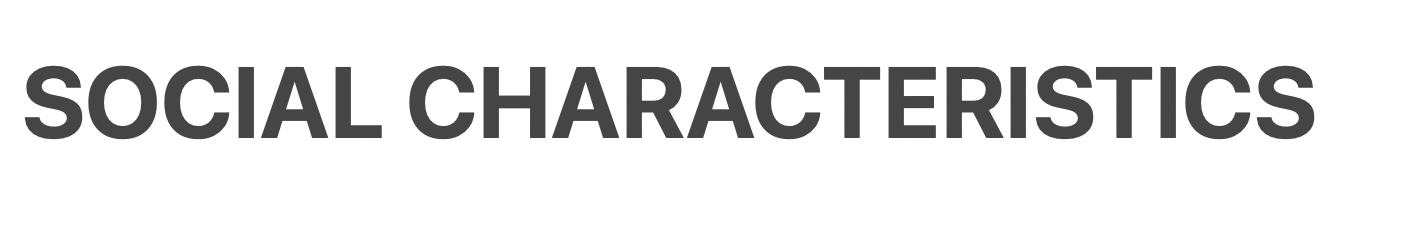

# 3.a SOCIAL data (treating the same way, but only updating the functions for update_titles and clean_up_data) 

In [34]:
## LOAD_AND_RENAME_DATA FUNCTION REMAINS THE SAME
AL_social_df = load_and_rename_data('data/ALLCD_DP02_AL.csv')

In [35]:
def update_titles_social(data):
    # Create the title_dict
    title_dict = dict(zip(data['PROFLN'], data['TITLE']))

    ####### DICTIONARIES FOR PROFLN NUMBERS THAT NEED A DIRECT MAPPING#######
    # "HOUSEHOLDS BY TYPE" category
    households_by_type_dict = {
        '2': '1-2', '3': '1-2-3', '4': '1-4', '5': '1-4-5',
        '6': '1-6', '7': '1-6-7', '8': '1-6-8', '9': '1-6-9',
        '10': '1-10', '11': '1-10-11', '12': '1-10-12', '13': '1-10-13'
    }
    # "FERTILITY" category
    fertility_dict = {
        '37': '36.5-37', '38': '36.5-38', '39': '36.5-37-39', 
        '40': '36.5-37-40', '41': '36.5-37-41', '42': '36.5-37-42', 
        '43': '36.5-37-43'
    }
    # "GRANDPARENTS" category
    grandparents_dict = {
        '44': '43.5-44', '45': '43.5-44-45', '45.9': '45-45.9',
        '46': '45-45.9-46', '47': '45-45.9-47', '48': '45-45.9-48',
        '49': '45-45.9-49', '51': '50-51', '52': '50-52'
    }
    # "VETERAN STATUS" category
    veteran_status_dict = {
        '69': '68.5-69', '70': '68.5-70'
    }
    # "PLACE OF BIRTH" category
    place_of_birth_dict = {
        '88': '87.5-88', '89': '87.5-89', '90': '87.5-89-90', 
        '91': '87.5-89-91', '92': '87.5-89-92', '93': '87.5-89-93', 
        '94': '87.5-94'
    }
    # "U.S. CITIZENSHIP STATUS" category
    citizenship_status_dict = {
        '96': '95-96', '97': '95-97'
    }
    # "YEAR OF ENTRY" category
    year_of_entry_dict = {
        '99': '98-99', '100': '98-99-100', '101': '98-99-101',
        '102': '98-102', '103': '98-102-103', '104': '98-102-104'
    }
    # "LANGUAGE SPOKEN AT HOME" category
    language_spoken_dict = {
        '112': '111.5-112', '113': '111.5-113', '114': '111.5-114',
        '115': '111.5-114-115', '116': '111.5-116', '117': '111.5-114-117',
        '118': '111.5-118', '119': '111.5-118-119', '120': '111.5-120',
        '121': '111.5-120-121', '122': '111.5-114-122', '123': '111.5-114-122-123'
    }
    # "COMPUTERS AND INTERNET USE" category
    computers_and_internet_use_dict = {
        '152': '151.5-152', 
        '153': '151.5-152-153', 
        '154': '151.5-152-154'
    }
    

    ###### PROFLN NUMBERS THAT FOLLOW A SIMPLE PATTERN OVER A LONG RANGE######
    # "RELATIONSHIP" category
    for i in range(19, 25):
        data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '18-' + str(i)
    # "MARITAL STATUS" category
    for i in range(26, 31):
        data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '25-' + str(i)
    for i in range(32, 37):
        data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '31-' + str(i)
    # "SCHOOL ENROLLMENT" category
    for i in range(54, 59):
        data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '53-' + str(i)
    # "EDUCATIONAL ATTAINMENT" category
    for i in range(59, 69):
        data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '58.5-59' + ('' if i == 59 else '-' + str(i))
    # "DISABILITY STATUS OF THE CIVILIAN NONINSTITUTIONALIZED POPULATION" category
    for i in range(72, 79):
        data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '71-' + str(i)
    # "RESIDENCE 1 YEAR AGO" category
    for i in range(80, 88):
        data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '78.5-' + str(i)
    # "WORLD REGION OF BIRTH OF FOREIGN BORN" category
    for i in range(105, 112):
        data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '104.5-' + str(i)
    # "ANCESTRY" category
    for i in range(125, 152):
        data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '123.5-' + str(i)



    ###### DIRECT MAPPING #####
    for old, new in households_by_type_dict.items():
        data.loc[data['PROFLN'] == old, 'PROFLN'] = new
    for old, new in fertility_dict.items():
        data.loc[data['PROFLN'] == old, 'PROFLN'] = new
    for old, new in grandparents_dict.items():
        data.loc[data['PROFLN'] == old, 'PROFLN'] = new
    for old, new in veteran_status_dict.items():
        data.loc[data['PROFLN'] == old, 'PROFLN'] = new
    for old, new in place_of_birth_dict.items():
        data.loc[data['PROFLN'] == old, 'PROFLN'] = new
    for old, new in citizenship_status_dict.items():
        data.loc[data['PROFLN'] == old, 'PROFLN'] = new
    for old, new in year_of_entry_dict.items():
        data.loc[data['PROFLN'] == old, 'PROFLN'] = new
    for old, new in language_spoken_dict.items():
        data.loc[data['PROFLN'] == old, 'PROFLN'] = new
    for old, new in computers_and_internet_use_dict.items():
        data.loc[data['PROFLN'] == old, 'PROFLN'] = new

    # Translate TITLE values using previously defined 'translate_profln' function
    data['PROFLN'] = data['PROFLN'].astype(str)
    data['TITLE'] = data['PROFLN'].apply(lambda x: translate_profln(x, title_dict))



    return data


In [36]:
AL_social_df = update_titles_social(AL_social_df)

In [37]:
# CLEAN UP DATA AND DROP REDUNDANT INFO FROM SOCIAL DATASET FUNCTION

def clean_up_data_social(data):
    # drop unneccessary rows and rows with placeholders
    invalid_rows = (data['PRF_ESTIMATE'].isin(['N', '(X)']) | 
                data['PCT_ESTIMATE'].isin(['N', '(X)']) |
                data['PRF_ESTIMATE'].isna())
    data = data[~invalid_rows]

    # Drop rows where 'TITLE' contains 'Not computed'
    data = data[~data['TITLE'].str.contains('Not computed', na=False)]

    # The rows associated with these (profln) contain duplicated data
    profln_to_remove = ['50','95','98-102', 
                        '1','152','124']  # Duplicated Grandparents, Foreign born, Total households, total pop               
    
    data = data[~data['PROFLN'].isin(profln_to_remove)]

    # Delete the margin of error columns
    data = data.drop(columns=['PRF_MG_ERROR', 'PCT_MG_ERROR'])

    # Replace '(X)' values in PCT_ESTIMATE with their PRF_ESTIMATE values (usually average and median values)
    data.loc[data['PCT_ESTIMATE'] == '(X)', 'PCT_ESTIMATE'] = data['PRF_ESTIMATE']

    # Remove '+' and ',' from 'PCT_ESTIMATE' and 'PRF_ESTIMATE', then convert to float
    for col in ['PCT_ESTIMATE', 'PRF_ESTIMATE']:
        data[col] = data[col].str.replace(',', '').str.replace('+', '').astype(float)
    
    return data



In [38]:
AL_social_df = clean_up_data_social(AL_social_df)

In [39]:
format_districts(AL_social_df)

,TBLID,GEOID,District,PROFLN,TITLE,PRF_ESTIMATE,PCT_ESTIMATE,Formatted_District
4,DP02,5001800US0101,"Congressional District 1 (118th Congress), Alabama",1-2,Total households - Married-couple household,130334.0,45.8,AL-01
5,DP02,5001800US0101,"Congressional District 1 (118th Congress), Alabama",1-2-3,Total households - Married-couple household - With children of the householder under 18 years,43295.0,15.2,AL-01
6,DP02,5001800US0101,"Congressional District 1 (118th Congress), Alabama",1-4,Total households - Cohabiting couple household,15486.0,5.4,AL-01
7,DP02,5001800US0101,"Congressional District 1 (118th Congress), Alabama",1-4-5,Total households - Cohabiting couple household - With children of the householder under 18 years,5100.0,1.8,AL-01
8,DP02,5001800US0101,"Congressional District 1 (118th Congress), Alabama",1-6,"Total households - Male householder, no spouse/partner present",48843.0,17.2,AL-01
...,...,...,...,...,...,...,...,...
1393,DP02,5001800US0107,"Congressional District 7 (118th Congress), Alabama",123.5-150,ANCESTRY - Welsh,1085.0,0.2,AL-07
1394,DP02,5001800US0107,"Congressional District 7 (118th Congress), Alabama",123.5-151,ANCESTRY - West Indian (excluding Hispanic origin groups),1569.0,0.2,AL-07
1397,DP02,5001800US0107,"Congressional District 7 (118th Congress), Alabama",151.5-152,COMPUTERS AND INTERNET USE - Total households,281678.0,281678.0,AL-07
1398,DP02,5001800US0107,"Congressional District 7 (118th Congress), Alabama",151.5-152-153,COMPUTERS AND INTERNET USE - Total households - With a computer,256911.0,91.2,AL-07


In [40]:
AL_social_prf, AL_social_pct = reorient_dfs(AL_social_df)

In [41]:
AL_social_prf

,Formatted_District,GEOID,ANCESTRY - American,ANCESTRY - Arab,ANCESTRY - Czech,ANCESTRY - Danish,ANCESTRY - Dutch,ANCESTRY - English,ANCESTRY - French (except Basque),ANCESTRY - French Canadian,...,"Total households - Female householder, no spouse/partner present - Householder living alone","Total households - Female householder, no spouse/partner present - With children of the householder under 18 years","Total households - Male householder, no spouse/partner present","Total households - Male householder, no spouse/partner present - 65 years and over","Total households - Male householder, no spouse/partner present - Householder living alone","Total households - Male householder, no spouse/partner present - With children of the householder under 18 years",Total households - Married-couple household,Total households - Married-couple household - With children of the householder under 18 years,VETERAN STATUS - Civilian population 18 years and over,VETERAN STATUS - Civilian veterans
0,AL-01,5001800US0101,85851.0,2898.0,3103.0,1494.0,4165.0,80842.0,17792.0,2262.0,...,51827.0,16909.0,48843.0,11128.0,37814.0,2255.0,130334.0,43295.0,562917.0,49759.0
1,AL-02,5001800US0102,111963.0,428.0,576.0,1907.0,2751.0,78863.0,7619.0,669.0,...,48383.0,22848.0,50949.0,11646.0,38804.0,3786.0,121419.0,41229.0,541141.0,54312.0
2,AL-03,5001800US0103,89427.0,386.0,1364.0,266.0,3261.0,89071.0,4829.0,1280.0,...,45152.0,16901.0,56789.0,10755.0,40885.0,3686.0,128714.0,42975.0,564164.0,45780.0
3,AL-04,5001800US0104,127339.0,18.0,298.0,97.0,2780.0,99468.0,5918.0,496.0,...,41982.0,12226.0,46599.0,11415.0,35201.0,2391.0,140299.0,50644.0,557197.0,36859.0
4,AL-05,5001800US0105,73905.0,914.0,824.0,1070.0,7210.0,109339.0,8309.0,1338.0,...,46009.0,13644.0,52783.0,10481.0,38992.0,4165.0,148603.0,54416.0,570798.0,56560.0
5,AL-06,5001800US0106,69237.0,3851.0,782.0,2132.0,3306.0,108847.0,7118.0,634.0,...,46059.0,12872.0,46798.0,9359.0,33613.0,2995.0,142940.0,54564.0,544098.0,33133.0
6,AL-07,5001800US0107,88905.0,1073.0,96.0,117.0,1089.0,47126.0,4058.0,408.0,...,55289.0,23437.0,62561.0,13149.0,47170.0,3945.0,92083.0,27921.0,558857.0,38739.0


# 3.b - SOCIAL Data -- (cleaning and applying social data to all 50 states)

In [42]:
## PROCESS ALL 50 STATES HOUSING FUNCTION
def process_social(file_state_list):
    prf_dfs = []
    pct_dfs = []
    
    for file_state in file_state_list:
        csv, state = file_state

        data = load_and_rename_data(csv)
        data = update_titles_social(data)
        data = clean_up_data_social(data)
        data = format_districts(data)

        prf_estimate_df, pct_estimate_df = reorient_dfs(data)

        prf_dfs.append(prf_estimate_df)
        pct_dfs.append(pct_estimate_df)
    
    df_prfsocial_all = pd.concat(prf_dfs, ignore_index=True)
    df_pctsocial_all = pd.concat(pct_dfs, ignore_index=True)
    
    return df_prfsocial_all, df_pctsocial_all


In [43]:
file_state_list = [
 ('data/ALLCD_DP02_AK.csv', 'AK'),('data/ALLCD_DP02_AL.csv', 'AL'),('data/ALLCD_DP02_AR.csv', 'AR'),
 ('data/ALLCD_DP02_AZ.csv', 'AZ'),('data/ALLCD_DP02_CA.csv', 'CA'),('data/ALLCD_DP02_CO.csv', 'CO'),
 ('data/ALLCD_DP02_CT.csv', 'CT'),('data/ALLCD_DP02_DE.csv', 'DE'),('data/ALLCD_DP02_FL.csv', 'FL'),
 ('data/ALLCD_DP02_GA.csv', 'GA'),('data/ALLCD_DP02_HI.csv', 'HI'),('data/ALLCD_DP02_IA.csv', 'IA'),
 ('data/ALLCD_DP02_ID.csv', 'ID'),('data/ALLCD_DP02_IL.csv', 'IL'),('data/ALLCD_DP02_IN.csv', 'IN'),
 ('data/ALLCD_DP02_KS.csv', 'KS'),('data/ALLCD_DP02_KY.csv', 'KY'),('data/ALLCD_DP02_LA.csv', 'LA'),
 ('data/ALLCD_DP02_MA.csv', 'MA'),('data/ALLCD_DP02_MD.csv', 'MD'),('data/ALLCD_DP02_ME.csv', 'ME'),
 ('data/ALLCD_DP02_MI.csv', 'MI'),('data/ALLCD_DP02_MN.csv', 'MN'),('data/ALLCD_DP02_MO.csv', 'MO'),
 ('data/ALLCD_DP02_MS.csv', 'MS'),('data/ALLCD_DP02_MT.csv', 'MT'),('data/ALLCD_DP02_NC.csv', 'NC'),
 ('data/ALLCD_DP02_ND.csv', 'ND'),('data/ALLCD_DP02_NE.csv', 'NE'),('data/ALLCD_DP02_NH.csv', 'NH'),
 ('data/ALLCD_DP02_NJ.csv', 'NJ'),('data/ALLCD_DP02_NM.csv', 'NM'),('data/ALLCD_DP02_NV.csv', 'NV'),
 ('data/ALLCD_DP02_NY.csv', 'NY'),('data/ALLCD_DP02_OH.csv', 'OH'),('data/ALLCD_DP02_OK.csv', 'OK'),
 ('data/ALLCD_DP02_OR.csv', 'OR'),('data/ALLCD_DP02_PA.csv', 'PA'),('data/ALLCD_DP02_RI.csv', 'RI'),
 ('data/ALLCD_DP02_SC.csv', 'SC'),('data/ALLCD_DP02_SD.csv', 'SD'),('data/ALLCD_DP02_TN.csv', 'TN'),
 ('data/ALLCD_DP02_TX.csv', 'TX'),('data/ALLCD_DP02_UT.csv', 'UT'),('data/ALLCD_DP02_VA.csv', 'VA'),
 ('data/ALLCD_DP02_VT.csv', 'VT'),('data/ALLCD_DP02_WA.csv', 'WA'),('data/ALLCD_DP02_WI.csv', 'WI'),
 ('data/ALLCD_DP02_WV.csv', 'WV'),('data/ALLCD_DP02_WY.csv', 'WY')
]


df_prfsocial_all, df_pctsocial_all = process_social(file_state_list)


In [44]:
df_pctsocial_all

,Formatted_District,GEOID,ANCESTRY - American,ANCESTRY - Arab,ANCESTRY - Czech,ANCESTRY - Danish,ANCESTRY - Dutch,ANCESTRY - English,ANCESTRY - French (except Basque),ANCESTRY - French Canadian,...,Total households - Married-couple household - With children of the householder under 18 years,VETERAN STATUS - Civilian population 18 years and over,VETERAN STATUS - Civilian veterans,WORLD REGION OF BIRTH OF FOREIGN BORN - Africa,WORLD REGION OF BIRTH OF FOREIGN BORN - Asia,WORLD REGION OF BIRTH OF FOREIGN BORN - Europe,"WORLD REGION OF BIRTH OF FOREIGN BORN - Foreign-born population, excluding population born at sea",WORLD REGION OF BIRTH OF FOREIGN BORN - Latin America,WORLD REGION OF BIRTH OF FOREIGN BORN - Northern America,WORLD REGION OF BIRTH OF FOREIGN BORN - Oceania
0,AK-AL,5001800US0200,3.1,0.3,0.6,0.7,1.5,10.2,2.1,0.6,...,19.9,528863.0,11.0,4.7,57.6,12.7,59061.0,17.1,3.2,4.7
1,AL-01,5001800US0101,11.8,0.4,0.4,0.2,0.6,11.1,2.4,0.3,...,15.2,562917.0,8.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AL-02,5001800US0102,15.6,0.1,0.1,0.3,0.4,11.0,1.1,0.1,...,14.8,541141.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AL-03,5001800US0103,12.4,0.1,0.2,0.0,0.5,12.3,0.7,0.2,...,15.4,564164.0,8.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AL-04,5001800US0104,17.6,0.0,0.0,0.0,0.4,13.8,0.8,0.1,...,18.7,557197.0,6.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,WI-07,5001800US5507,3.9,0.1,1.7,0.8,1.5,6.5,2.6,1.1,...,15.9,586492.0,8.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
431,WI-08,5001800US5508,3.7,0.2,1.4,0.7,4.5,5.4,3.4,1.2,...,18.0,574050.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
432,WV-01,5001800US5401,10.4,0.4,0.1,0.0,0.6,18.9,1.0,0.1,...,14.0,700175.0,7.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
433,WV-02,5001800US5402,8.6,0.4,0.1,0.1,1.0,13.9,1.2,0.2,...,15.5,719383.0,7.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN


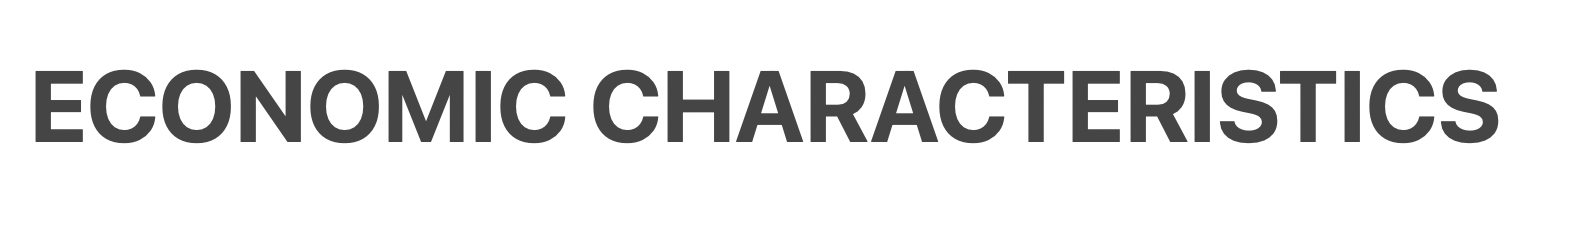

# 4.a ECON data (treating the same way, but only updating the functions for update_titles and clean_up_data) 


In [45]:
AL_econ_df = load_and_rename_data('data/ALLCD_DP03_AL.csv')

In [46]:
def update_titles_econ(data):
   
    # Shorten two long titles--
    #INCOME AND BENEFITS (IN 2021 INFLATION-ADJUSTED DOLLARS)
    data.loc[data['PROFLN'] == '50.5', 'TITLE'] = 'INCOME AND BENEFITS' 
    #PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL
    data.loc[data['PROFLN'] == '118.5', 'TITLE'] = 'INCOME BELOW POVERTY LEVEL' 
   
    # now create the title_dict
    title_dict = dict(zip(data['PROFLN'], data['TITLE']))

    ####### DICTIONARIES FOR PROFLN NUMBERS THAT NEED A DIRECT MAPPING#######
    
    # Dictionary "MISC FEMALE EMPLOYMENT"
    misc_female_employment_dict = {
        '15': '0.8-1-14-15',
        '16': '0.8-10-16',
        '17': '0.8-10-16-17'
    }
    # Dictionary "MISC INCOME AND BENEFITS" category
    misc_income_and_benefits_dict = {
        '65': '50.5-51-64-65',
        '66': '50.5-51-66',
        '67': '50.5-51-66-67',
        '68': '50.5-51-68',
        '69': '50.5-51-68-69',
        '70': '50.5-51-70',
        '71': '50.5-51-70-71',
        '72': '50.5-51-72',
        '73': '50.5-51-72-73',
        '74': '50.5-51-74',
    }
    
    # Dictionary HEALTH INSURANCE COVERAGE category
    health_insurance_coverage_dict = {
        '95': '94.5-95',
        '96': '94.5-95-96',
        '97': '94.5-95-97',
        '98': '94.5-95-98',
        '99': '94.5-95-99',
        '100': '94.5-100',
        '101': '94.5-100-101',
        '103': '102-103',
        '104': '94.5-104',
        '105': '94.5-104-105',
        '106': '94.5-104-106',
        '107': '94.5-104-107',
        '108': '94.5-104-108',
        '109': '94.5-109',
        '110': '94.5-109-110',
        '111': '94.5-109-111',
        '112': '94.5-109-112',
        '113': '94.5-109-113',
        '114': '94.5-114',
        '115': '94.5-114-115',
        '116': '94.5-114-116',
        '117': '94.5-114-117',
        '118': '94.5-114-118'
    }
    # Dictionary FAMILY POVERTY LEVEL
    family_poverty_level_dict = {
        '119': '118.5-119',
        '120': '118.5-119-120',
        '121': '118.5-119-121',
        '122': '118.5-122',
        '123': '118.5-122-123',
        '124': '118.5-122-124',
        '125': '118.5-125',
        '126': '118.5-125-126',
        '127': '118.5-125-127'
    }


    ###### PROFLN NUMBERS THAT FOLLOW A SIMPLE PATTERN OVER A LONG RANGE######
    # EMPLOYMENT STATUS category
    for i in range(1, 10):
        data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '0.8-1' + ('' if i == 1 else '-' + str(i))
    # "FEMALE EMPLOYMENT STATUS" category
    for i in range(10, 15):
        data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '0.8-10' + ('' if i == 10 else '-' + str(i))
    # "COMMUTING TO WORK" category
    for i in range(18, 26):
        data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '17.5-' + str(i)
    # "OCCUPATION" category
    for i in range(26, 32):
        data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '25.5-' + str(i)
    # "INDUSTRY" category
    for i in range(33, 46):
        data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '31.5-' + str(i)
    #"CLASS OF WORKER" category
    for i in range(47, 51):
        data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '45.5-' + str(i)
    # "INCOME AND BENEFITS" category
    for i in range(52, 65):
        data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '50.5-51-' + str(i)
    # FAMILY INCOME AND BENEFITS category
    for i in range(75, 88):
        data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '50.5-75' + ('' if i == 75 else '-' + str(i))
    # NON-FAMILY INCOME AND BENEFITS category
    for i in range(88, 95):
        data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '50.5-' + str(i)
    # ALL PEOPLE POVERTY LEVEL category
    for i in range (128,138):
        data.loc[data['PROFLN'] == str(i), 'PROFLN'] = '118.5-128'+ ('' if i == 128 else '-' + str(i))
    
    
    ###### DIRECT MAPPING #####
    for old, new in misc_female_employment_dict.items(): #Misc Female Employment
        data.loc[data['PROFLN'] == old, 'PROFLN'] = new
    for old, new in misc_income_and_benefits_dict.items(): #Misc income and benefits
        data.loc[data['PROFLN'] == old, 'PROFLN'] = new
    for old, new in health_insurance_coverage_dict.items(): #Health Insurance Coverage
        data.loc[data['PROFLN'] == old, 'PROFLN'] = new
    for old, new in family_poverty_level_dict.items():     # Family poverty level
        data.loc[data['PROFLN'] == old, 'PROFLN'] = new
    

    # Translate TITLE values using previously defined 'translate_profln' function
    data['PROFLN'] = data['PROFLN'].astype(str)
    data['TITLE'] = data['PROFLN'].apply(lambda x: translate_profln(x, title_dict))

    return data


In [47]:
AL_econ_df = update_titles_econ(AL_econ_df)
AL_econ_df[['PROFLN','TITLE']]

,PROFLN,TITLE
0,0,SELECTED ECONOMIC CHARACTERISTICS
1,0.5,nan
2,0.8,EMPLOYMENT STATUS
3,0.8-1,EMPLOYMENT STATUS - Population 16 years and over
4,0.8-1-2,EMPLOYMENT STATUS - Population 16 years and over - In labor force
...,...,...
1171,118.5-128-133,INCOME BELOW POVERTY LEVEL - All people - 18 years and over
1172,118.5-128-134,INCOME BELOW POVERTY LEVEL - All people - 18 to 64 years
1173,118.5-128-135,INCOME BELOW POVERTY LEVEL - All people - 65 years and over
1174,118.5-128-136,INCOME BELOW POVERTY LEVEL - All people - People in families


In [48]:
def clean_up_data_econ(data):
    
    # Replace '(X)' values in PCT_ESTIMATE with their PRF_ESTIMATE values (and vice versa)
    data.loc[data['PCT_ESTIMATE'] == '(X)', 'PCT_ESTIMATE'] = data['PRF_ESTIMATE']
    data.loc[data['PRF_ESTIMATE'] == '(X)', 'PRF_ESTIMATE'] = data['PCT_ESTIMATE']
    
    
    # Drop unnecessary rows and rows with placeholders
    invalid_rows = (data['PRF_ESTIMATE'].isin(['N', '(X)']) | 
                data['PCT_ESTIMATE'].isin(['N', '(X)']) |
                data['PRF_ESTIMATE'].isna())
    data = data[~invalid_rows]

    # Drop rows where 'TITLE' contains 'Not computed'
    data = data[~data['TITLE'].str.contains('Not computed', na=False)]

    # The rows associated with these (profln) contain duplicated data
    profln_to_remove = ['25.5-26', '32', '46',   # Duplicated 'Employed population 16+'
                        '0.8-1-8']               # Duplicated 'Civilian labor force'
    
    data = data[~data['PROFLN'].isin(profln_to_remove)]

    # Delete the margin of error columns
    data = data.drop(columns=['PRF_MG_ERROR', 'PCT_MG_ERROR'])


    # Convert to number - Remove '+' and ',' from 'PCT_ESTIMATE' and 'PRF_ESTIMATE', then convert to float
    for col in ['PCT_ESTIMATE', 'PRF_ESTIMATE']:
        data[col] = data[col].str.replace(',', '').str.replace('+', '').astype(float)
    
    return data


In [49]:
AL_econ_df = clean_up_data_econ(AL_econ_df)

In [50]:
format_districts(AL_econ_df)

,TBLID,GEOID,District,PROFLN,TITLE,PRF_ESTIMATE,PCT_ESTIMATE,Formatted_District
3,DP03,5001800US0101,"Congressional District 1 (118th Congress), Alabama",0.8-1,EMPLOYMENT STATUS - Population 16 years and over,583074.0,583074.0,AL-01
4,DP03,5001800US0101,"Congressional District 1 (118th Congress), Alabama",0.8-1-2,EMPLOYMENT STATUS - Population 16 years and over - In labor force,335093.0,57.5,AL-01
5,DP03,5001800US0101,"Congressional District 1 (118th Congress), Alabama",0.8-1-3,EMPLOYMENT STATUS - Population 16 years and over - Civilian labor force,333456.0,57.2,AL-01
6,DP03,5001800US0101,"Congressional District 1 (118th Congress), Alabama",0.8-1-4,EMPLOYMENT STATUS - Population 16 years and over - Employed,314029.0,53.9,AL-01
7,DP03,5001800US0101,"Congressional District 1 (118th Congress), Alabama",0.8-1-5,EMPLOYMENT STATUS - Population 16 years and over - Unemployed,19427.0,3.3,AL-01
...,...,...,...,...,...,...,...,...
1171,DP03,5001800US0107,"Congressional District 7 (118th Congress), Alabama",118.5-128-133,INCOME BELOW POVERTY LEVEL - All people - 18 years and over,19.6,19.6,AL-07
1172,DP03,5001800US0107,"Congressional District 7 (118th Congress), Alabama",118.5-128-134,INCOME BELOW POVERTY LEVEL - All people - 18 to 64 years,20.9,20.9,AL-07
1173,DP03,5001800US0107,"Congressional District 7 (118th Congress), Alabama",118.5-128-135,INCOME BELOW POVERTY LEVEL - All people - 65 years and over,15.2,15.2,AL-07
1174,DP03,5001800US0107,"Congressional District 7 (118th Congress), Alabama",118.5-128-136,INCOME BELOW POVERTY LEVEL - All people - People in families,20.7,20.7,AL-07


In [51]:
AL_econ_prf, AL_econ_pct = reorient_dfs(AL_econ_df)
AL_econ_prf

,Formatted_District,GEOID,CLASS OF WORKER - Government workers,CLASS OF WORKER - Private wage and salary workers,CLASS OF WORKER - Self-employed in own not incorporated business workers,CLASS OF WORKER - Unpaid family workers,"COMMUTING TO WORK - Car, truck, or van -- carpooled","COMMUTING TO WORK - Car, truck, or van -- drove alone",COMMUTING TO WORK - Mean travel time to work (minutes),COMMUTING TO WORK - Other means,...,INDUSTRY - Public administration,INDUSTRY - Retail trade,"INDUSTRY - Transportation and warehousing, and utilities",INDUSTRY - Wholesale trade,"OCCUPATION - Management, business, science, and arts occupations","OCCUPATION - Natural resources, construction, and maintenance occupations","OCCUPATION - Production, transportation, and material moving occupations",OCCUPATION - Sales and office occupations,OCCUPATION - Service occupations,Total households
0,AL-01,5001800US0101,50470.0,245427.0,18085.0,47.0,20665.0,252238.0,26.6,3289.0,...,15685.0,41999.0,16722.0,8131.0,106525.0,33295.0,49331.0,69133.0,55745.0,284318.0
1,AL-02,5001800US0102,52999.0,226848.0,17456.0,568.0,19641.0,256715.0,24.1,3722.0,...,23376.0,34878.0,20794.0,6156.0,100393.0,28405.0,56946.0,65422.0,46705.0,278370.0
2,AL-03,5001800US0103,50660.0,229463.0,14093.0,213.0,24235.0,235963.0,26.0,4215.0,...,13598.0,32975.0,18177.0,4214.0,103569.0,30712.0,50175.0,60570.0,49403.0,278736.0
3,AL-04,5001800US0104,40569.0,247849.0,19846.0,130.0,29722.0,253264.0,25.2,1320.0,...,10153.0,41709.0,18947.0,7008.0,96097.0,34778.0,69378.0,59951.0,48190.0,271053.0
4,AL-05,5001800US0105,62558.0,260749.0,17666.0,810.0,23614.0,257368.0,24.4,3959.0,...,26321.0,36115.0,17078.0,6821.0,159043.0,28587.0,49293.0,61892.0,42968.0,294256.0
5,AL-06,5001800US0106,48426.0,277562.0,17422.0,265.0,24232.0,261958.0,27.0,3200.0,...,15564.0,39310.0,18490.0,11981.0,156198.0,31589.0,40197.0,70045.0,45646.0,279148.0
6,AL-07,5001800US0107,49367.0,225287.0,15865.0,215.0,23240.0,225829.0,23.9,3391.0,...,11651.0,36029.0,19159.0,4160.0,95401.0,23236.0,57616.0,56690.0,57791.0,281678.0


# 4.b ECON data (applying ECON treatment to all 50 states and joining) 


In [52]:
## PROCESS ALL 50 STATES HOUSING FUNCTION
def process_econ(file_state_list):
    prf_dfs = []
    pct_dfs = []
    
    for file_state in file_state_list:
        csv, state = file_state

        data = load_and_rename_data(csv)
        data = update_titles_econ(data)
        data = clean_up_data_econ(data)
        data = format_districts(data)

        prf_estimate_df, pct_estimate_df = reorient_dfs(data)

        prf_dfs.append(prf_estimate_df)
        pct_dfs.append(pct_estimate_df)
    
    df_prfecon_all = pd.concat(prf_dfs, ignore_index=True)
    df_pctecon_all = pd.concat(pct_dfs, ignore_index=True)
    
    return df_prfecon_all, df_pctecon_all


In [53]:
file_state_list = [
 ('data/ALLCD_DP03_AK.csv', 'AK'),('data/ALLCD_DP03_AL.csv', 'AL'),('data/ALLCD_DP03_AR.csv', 'AR'),
 ('data/ALLCD_DP03_AZ.csv', 'AZ'),('data/ALLCD_DP03_CA.csv', 'CA'),('data/ALLCD_DP03_CO.csv', 'CO'),
 ('data/ALLCD_DP03_CT.csv', 'CT'),('data/ALLCD_DP03_DE.csv', 'DE'),('data/ALLCD_DP03_FL.csv', 'FL'),
 ('data/ALLCD_DP03_GA.csv', 'GA'),('data/ALLCD_DP03_HI.csv', 'HI'),('data/ALLCD_DP03_IA.csv', 'IA'),
 ('data/ALLCD_DP03_ID.csv', 'ID'),('data/ALLCD_DP03_IL.csv', 'IL'),('data/ALLCD_DP03_IN.csv', 'IN'),
 ('data/ALLCD_DP03_KS.csv', 'KS'),('data/ALLCD_DP03_KY.csv', 'KY'),('data/ALLCD_DP03_LA.csv', 'LA'),
 ('data/ALLCD_DP03_MA.csv', 'MA'),('data/ALLCD_DP03_MD.csv', 'MD'),('data/ALLCD_DP03_ME.csv', 'ME'),
 ('data/ALLCD_DP03_MI.csv', 'MI'),('data/ALLCD_DP03_MN.csv', 'MN'),('data/ALLCD_DP03_MO.csv', 'MO'),
 ('data/ALLCD_DP03_MS.csv', 'MS'),('data/ALLCD_DP03_MT.csv', 'MT'),('data/ALLCD_DP03_NC.csv', 'NC'),
 ('data/ALLCD_DP03_ND.csv', 'ND'),('data/ALLCD_DP03_NE.csv', 'NE'),('data/ALLCD_DP03_NH.csv', 'NH'),
 ('data/ALLCD_DP03_NJ.csv', 'NJ'),('data/ALLCD_DP03_NM.csv', 'NM'),('data/ALLCD_DP03_NV.csv', 'NV'),
 ('data/ALLCD_DP03_NY.csv', 'NY'),('data/ALLCD_DP03_OH.csv', 'OH'),('data/ALLCD_DP03_OK.csv', 'OK'),
 ('data/ALLCD_DP03_OR.csv', 'OR'),('data/ALLCD_DP03_PA.csv', 'PA'),('data/ALLCD_DP03_RI.csv', 'RI'),
 ('data/ALLCD_DP03_SC.csv', 'SC'),('data/ALLCD_DP03_SD.csv', 'SD'),('data/ALLCD_DP03_TN.csv', 'TN'),
 ('data/ALLCD_DP03_TX.csv', 'TX'),('data/ALLCD_DP03_UT.csv', 'UT'),('data/ALLCD_DP03_VA.csv', 'VA'),
 ('data/ALLCD_DP03_VT.csv', 'VT'),('data/ALLCD_DP03_WA.csv', 'WA'),('data/ALLCD_DP03_WI.csv', 'WI'),
 ('data/ALLCD_DP03_WV.csv', 'WV'),('data/ALLCD_DP03_WY.csv', 'WY')
]


df_prfecon_all, df_pctecon_all = process_econ(file_state_list)


In [54]:
df_pctecon_all

,Formatted_District,GEOID,CLASS OF WORKER - Government workers,CLASS OF WORKER - Private wage and salary workers,CLASS OF WORKER - Self-employed in own not incorporated business workers,CLASS OF WORKER - Unpaid family workers,"COMMUTING TO WORK - Car, truck, or van -- carpooled","COMMUTING TO WORK - Car, truck, or van -- drove alone",COMMUTING TO WORK - Mean travel time to work (minutes),COMMUTING TO WORK - Other means,...,INDUSTRY - Public administration,INDUSTRY - Retail trade,"INDUSTRY - Transportation and warehousing, and utilities",INDUSTRY - Wholesale trade,"OCCUPATION - Management, business, science, and arts occupations","OCCUPATION - Natural resources, construction, and maintenance occupations","OCCUPATION - Production, transportation, and material moving occupations",OCCUPATION - Sales and office occupations,OCCUPATION - Service occupations,Total households
0,AK-AL,5001800US0200,25.8,67.8,6.1,0.3,11.1,66.2,19.8,4.8,...,12.2,10.1,9.4,1.2,39.9,10.7,13.7,18.4,17.2,271311.0
1,AL-01,5001800US0101,16.1,78.2,5.8,0.0,6.7,82.1,26.6,1.1,...,5.0,13.4,5.3,2.6,33.9,10.6,15.7,22.0,17.8,284318.0
2,AL-02,5001800US0102,17.8,76.2,5.9,0.2,6.5,85.2,24.1,1.2,...,7.8,11.7,7.0,2.1,33.7,9.5,19.1,22.0,15.7,278370.0
3,AL-03,5001800US0103,17.2,77.9,4.8,0.1,8.3,80.9,26.0,1.4,...,4.6,11.2,6.2,1.4,35.2,10.4,17.0,20.6,16.8,278736.0
4,AL-04,5001800US0104,13.2,80.4,6.4,0.0,9.8,83.4,25.2,0.4,...,3.3,13.5,6.1,2.3,31.2,11.3,22.5,19.4,15.6,271053.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,WI-07,5001800US5507,13.2,79.1,7.4,0.3,8.2,74.8,22.3,1.5,...,4.0,11.0,6.2,2.4,35.1,10.8,19.8,19.3,15.0,314894.0
431,WI-08,5001800US5508,11.3,83.2,5.3,0.2,6.6,75.6,21.1,1.6,...,3.3,10.3,5.5,2.4,38.3,10.3,18.9,18.7,13.8,305166.0
432,WV-01,5001800US5401,19.5,75.3,4.8,0.4,9.1,78.8,24.9,1.2,...,6.4,11.8,5.9,2.2,36.3,10.4,12.6,21.2,19.5,359332.0
433,WV-02,5001800US5402,20.3,75.2,4.3,0.2,8.6,75.7,26.4,1.4,...,6.8,12.2,5.9,1.6,37.9,10.0,15.1,19.6,17.3,362869.0


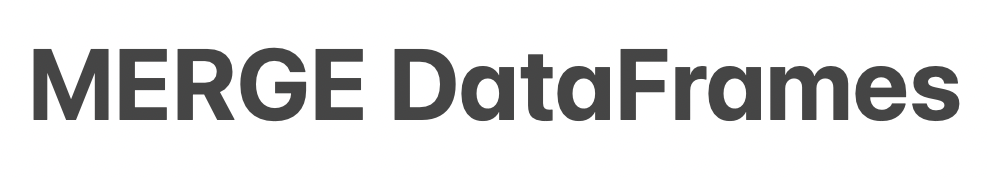

In [55]:
#merge all the PERCENT dataframes

df_pct_merged = pd.merge(df_pctdemo_all, df_pcthousing_all, on=['Formatted_District', 'GEOID'])
df_pct_merged = pd.merge(df_pct_merged, df_pctsocial_all, on=['Formatted_District', 'GEOID'])
df_pct_merged = pd.merge(df_pct_merged, df_pctecon_all, on=['Formatted_District', 'GEOID'])
# check shape to ensure we maintained all 435 districts
print(df_pct_merged.head())
print(df_pct_merged.shape)

  Formatted_District          GEOID  \
0              AK-AL  5001800US0200   
1              AL-01  5001800US0101   
2              AL-02  5001800US0102   
3              AL-03  5001800US0103   
4              AL-04  5001800US0104   

   CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population  \
0                                                          533852.0   
1                                                          555123.0   
2                                                          539010.0   
3                                                          558552.0   
4                                                          541258.0   

   CITIZEN, VOTING AGE POPULATION - Female  \
0                                     47.3   
1                                     52.2   
2                                     52.8   
3                                     51.8   
4                                     51.9   

   CITIZEN, VOTING AGE POPULATION - Male  HISPANIC OR LATINO 

In [56]:
#merge all the RAW NUMBER (PRF) dataframes

df_prf_merged = pd.merge(df_prfdemo_all, df_prfhousing_all, on=['Formatted_District', 'GEOID'])
df_prf_merged = pd.merge(df_prf_merged, df_prfsocial_all, on=['Formatted_District', 'GEOID'])
df_prf_merged = pd.merge(df_prf_merged, df_prfecon_all, on=['Formatted_District', 'GEOID'])
# check shape to ensure we maintained all 435 districts
print(df_prf_merged.head())
print(df_prf_merged.shape)

  Formatted_District          GEOID  \
0              AK-AL  5001800US0200   
1              AL-01  5001800US0101   
2              AL-02  5001800US0102   
3              AL-03  5001800US0103   
4              AL-04  5001800US0104   

   CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population  \
0                                                          533852.0   
1                                                          555123.0   
2                                                          539010.0   
3                                                          558552.0   
4                                                          541258.0   

   CITIZEN, VOTING AGE POPULATION - Female  \
0                                 252485.0   
1                                 289663.0   
2                                 284652.0   
3                                 289423.0   
4                                 280884.0   

   CITIZEN, VOTING AGE POPULATION - Male  HISPANIC OR LATINO 

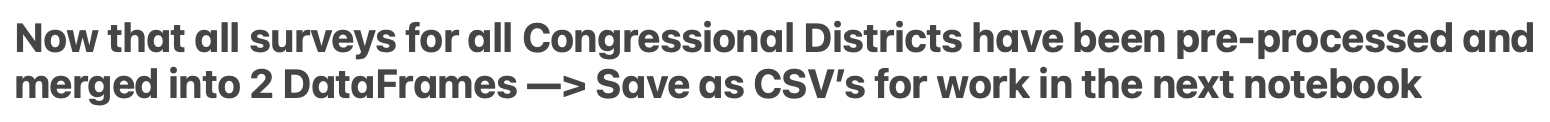

In [57]:
df_pct_merged.to_csv('data/ACS_Surveys_MERGED_Percentages.csv')
df_prf_merged.to_csv('data/ACS_Surveys_MERGED_Population.csv')

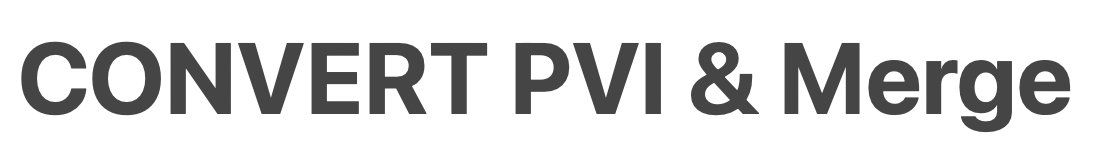

In [58]:
pvi_df = pd.read_csv('data/2023_PVI.csv')

In [59]:
def convert_pvi(pvi):
    # Check if the value is a string
    if isinstance(pvi, str):
        # Check the first character and convert the remainder of the string to a number
        if pvi[0] == 'D':
            return float(pvi[2:])
        elif pvi[0] == 'R':
            return -float(pvi[2:])
    # Return NaN for non-string values
    return float('nan')



In [60]:
pvi_df['2023 Raw PVI'] = pvi_df['2023 Raw PVI'].apply(convert_pvi)
pvi_df

,Dist,First,Last,Party,2023 PVI,2023 Raw PVI,Rank
0,AL-01,Jerry,Carl,R,R+16,-16.47,366
1,AL-02,Barry,Moore,R,R+17,-17.32,373
2,AL-03,Mike,Rogers,R,R+19,-19.36,393
3,AL-04,Robert,Aderholt,R,R+33,-33.24,435
4,AL-05,Dale,Strong,R,R+17,-16.67,370
...,...,...,...,...,...,...,...
430,WI-05,Scott,Fitzgerald,R,R+14,-14.29,342
431,WI-06,Glenn,Grothman,R,R+10,-10.24,294
432,WI-07,Tom,Tiffany,R,R+12,-12.27,315
433,WI-08,Mike,Gallagher,R,R+10,-10.16,293


In [61]:
pvi_df['Representative'] = pvi_df['Last'] + ", " + pvi_df['First']
pvi_df.head()


,Dist,First,Last,Party,2023 PVI,2023 Raw PVI,Rank,Representative
0,AL-01,Jerry,Carl,R,R+16,-16.47,366,"Carl, Jerry"
1,AL-02,Barry,Moore,R,R+17,-17.32,373,"Moore, Barry"
2,AL-03,Mike,Rogers,R,R+19,-19.36,393,"Rogers, Mike"
3,AL-04,Robert,Aderholt,R,R+33,-33.24,435,"Aderholt, Robert"
4,AL-05,Dale,Strong,R,R+17,-16.67,370,"Strong, Dale"


In [62]:
pvi_df  = pvi_df[['Dist','Representative','2023 Raw PVI']]

In [63]:
pvi_df = pvi_df.rename(columns={'Dist': 'Formatted_District', '2023 Raw PVI': 'PVI_2023'})


In [64]:
pvi_df

,Formatted_District,Representative,PVI_2023
0,AL-01,"Carl, Jerry",-16.47
1,AL-02,"Moore, Barry",-17.32
2,AL-03,"Rogers, Mike",-19.36
3,AL-04,"Aderholt, Robert",-33.24
4,AL-05,"Strong, Dale",-16.67
...,...,...,...
430,WI-05,"Fitzgerald, Scott",-14.29
431,WI-06,"Grothman, Glenn",-10.24
432,WI-07,"Tiffany, Tom",-12.27
433,WI-08,"Gallagher, Mike",-10.16


In [65]:
pvi_prf_df= pd.merge(df_prf_merged, pvi_df, on=['Formatted_District'])

In [66]:
pvi_pct_df= pd.merge(df_pct_merged, pvi_df, on=['Formatted_District'])

In [67]:
pvi_pct_df

,Formatted_District,GEOID,"CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population","CITIZEN, VOTING AGE POPULATION - Female","CITIZEN, VOTING AGE POPULATION - Male",HISPANIC OR LATINO AND RACE - Cuban,HISPANIC OR LATINO AND RACE - Hispanic or Latino (of any race),HISPANIC OR LATINO AND RACE - Mexican,HISPANIC OR LATINO AND RACE - Other Hispanic or Latino,HISPANIC OR LATINO AND RACE - Puerto Rican,...,"INDUSTRY - Transportation and warehousing, and utilities",INDUSTRY - Wholesale trade,"OCCUPATION - Management, business, science, and arts occupations","OCCUPATION - Natural resources, construction, and maintenance occupations","OCCUPATION - Production, transportation, and material moving occupations",OCCUPATION - Sales and office occupations,OCCUPATION - Service occupations,Total households,Representative,PVI_2023
0,AK-AL,5001800US0200,533852.0,47.3,52.7,0.4,7.1,3.0,2.5,1.2,...,9.4,1.2,39.9,10.7,13.7,18.4,17.2,271311.0,"Peltola, Mary",-8.02
1,AL-01,5001800US0101,555123.0,52.2,47.8,0.2,3.5,1.9,0.9,0.4,...,5.3,2.6,33.9,10.6,15.7,22.0,17.8,284318.0,"Carl, Jerry",-16.47
2,AL-02,5001800US0102,539010.0,52.8,47.2,0.1,4.1,2.6,0.8,0.6,...,7.0,2.1,33.7,9.5,19.1,22.0,15.7,278370.0,"Moore, Barry",-17.32
3,AL-03,5001800US0103,558552.0,51.8,48.2,0.1,3.2,1.6,0.9,0.6,...,6.2,1.4,35.2,10.4,17.0,20.6,16.8,278736.0,"Rogers, Mike",-19.36
4,AL-04,5001800US0104,541258.0,51.9,48.1,0.2,7.3,5.2,1.7,0.3,...,6.1,2.3,31.2,11.3,22.5,19.4,15.6,271053.0,"Aderholt, Robert",-33.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,WI-07,5001800US5507,579658.0,49.1,50.9,0.1,2.6,1.5,0.7,0.3,...,6.2,2.4,35.1,10.8,19.8,19.3,15.0,314894.0,"Tiffany, Tom",-12.27
431,WI-08,5001800US5508,562233.0,50.1,49.9,0.1,6.0,4.0,1.1,0.9,...,5.5,2.4,38.3,10.3,18.9,18.7,13.8,305166.0,"Gallagher, Mike",-10.16
432,WV-01,5001800US5401,696591.0,51.3,48.7,0.0,1.1,0.4,0.4,0.2,...,5.9,2.2,36.3,10.4,12.6,21.2,19.5,359332.0,"Miller, Carol",-23.23
433,WV-02,5001800US5402,712176.0,50.1,49.9,0.1,2.3,0.8,1.0,0.4,...,5.9,1.6,37.9,10.0,15.1,19.6,17.3,362869.0,"Mooney, Alex",-21.52


In [68]:
pvi_prf_df.to_csv('raw_2023_PVI_ACS.csv')

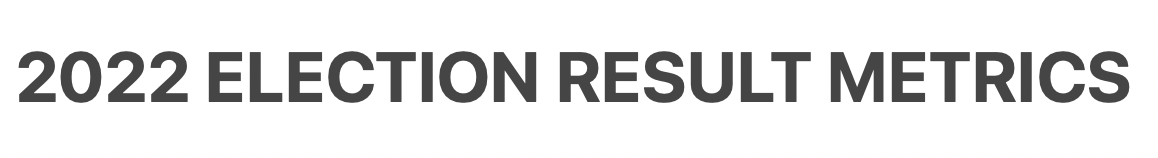

In [69]:
results_2022_metrics = pd.read_csv('data/2022_house_results.csv')

In [70]:
results_2022_metrics

,Formatted_District,Rep,Status,Dem Votes,Rep Votes,Other Votes,Dem %,Rep %,Other %,2022 Margin,Swing from 2020 presidential,Percent of 2020 turnout
0,AK-AL,Mary Peltola (D),Democratic hold,"137,263","112,471",0,55.0%,45.0%,0.0%,D+9.9,D+20,70%
1,AL-01,Jerry Carl (R),Republican hold,NaN,"140,592","27,558",0.0%,83.6%,16.4%,R+83.6,R+55.4,51%
2,AL-02,Barry Moore (R),Republican hold,"58,014","137,460","3,487",29.2%,69.1%,1.8%,R+39.9,R+10.6,62%
3,AL-03,Mike Rogers (R),Republican hold,"47,859","135,602","6,945",25.1%,71.2%,3.6%,R+46.1,R+12.1,60%
4,AL-04,Robert Aderholt (R),Republican hold,"26,694","164,655","4,384",13.6%,84.1%,2.2%,R+70.5,R+8.8,60%
...,...,...,...,...,...,...,...,...,...,...,...,...
430,WI-07,Tom Tiffany (R),Republican hold,"128,877","209,224",167,38.1%,61.9%,0.0%,R+23.8,R+3.8,80%
431,WI-08,Mike Gallagher (R),Republican hold,"5,320","223,981","78,928",1.7%,72.7%,25.6%,R+70.9,R+55.5,75%
432,WV-01,Carol Miller (R),Republican hold,"65,428","151,511","10,257",28.8%,66.7%,4.5%,R+37.9,D+3,58%
433,WV-02,Alex Mooney (R),Republican hold,"84,278","160,493",0,34.4%,65.6%,0.0%,R+31.1,D+5.9,61%


In [71]:
results_2022_metrics['2022 Margin'] = results_2022_metrics['2022 Margin'].apply(convert_pvi)
results_2022_metrics['Swing from 2020 presidential'] = \
results_2022_metrics['Swing from 2020 presidential'].apply(convert_pvi)


In [72]:
num_nan_dem = results_2022_metrics['Dem Votes'].isna().sum()
print(num_nan)
num_nan_rep = results_2022_metrics['Rep Votes'].isna().sum()
print(num_nan_rep)

NameError: name 'num_nan' is not defined

In [ ]:
num_zero_dem = (results_2022_metrics['Dem Votes'] == 0).sum()
print(num_zero_dem)

num_zero_rep = (results_2022_metrics['Rep Votes'] == 0).sum()
print(num_zero_rep)

In [73]:
# Replacing NaN values with 0's in races that ran unopposed
results_2022_metrics = results_2022_metrics.fillna({'Dem Votes': 0, 'Rep Votes': 0})

# Remove '%' and ',' then convert to float
cols = ['Dem %', 'Rep %', 'Other %','Dem Votes', 'Rep Votes', 'Other Votes']
for col in cols:
    results_2022_metrics.loc[:, col] = results_2022_metrics.loc[:, col].astype(str).str.replace('%', '').str.replace(',', '').astype(float)


In [74]:
results_2022_metrics['Dem Votes'].isna().sum()

0

In [75]:
results_2022_metrics

,Formatted_District,Rep,Status,Dem Votes,Rep Votes,Other Votes,Dem %,Rep %,Other %,2022 Margin,Swing from 2020 presidential,Percent of 2020 turnout
0,AK-AL,Mary Peltola (D),Democratic hold,137263.0,112471.0,0.0,55.0,45.0,0.0,9.9,20.0,70%
1,AL-01,Jerry Carl (R),Republican hold,0.0,140592.0,27558.0,0.0,83.6,16.4,-83.6,-55.4,51%
2,AL-02,Barry Moore (R),Republican hold,58014.0,137460.0,3487.0,29.2,69.1,1.8,-39.9,-10.6,62%
3,AL-03,Mike Rogers (R),Republican hold,47859.0,135602.0,6945.0,25.1,71.2,3.6,-46.1,-12.1,60%
4,AL-04,Robert Aderholt (R),Republican hold,26694.0,164655.0,4384.0,13.6,84.1,2.2,-70.5,-8.8,60%
...,...,...,...,...,...,...,...,...,...,...,...,...
430,WI-07,Tom Tiffany (R),Republican hold,128877.0,209224.0,167.0,38.1,61.9,0.0,-23.8,-3.8,80%
431,WI-08,Mike Gallagher (R),Republican hold,5320.0,223981.0,78928.0,1.7,72.7,25.6,-70.9,-55.5,75%
432,WV-01,Carol Miller (R),Republican hold,65428.0,151511.0,10257.0,28.8,66.7,4.5,-37.9,3.0,58%
433,WV-02,Alex Mooney (R),Republican hold,84278.0,160493.0,0.0,34.4,65.6,0.0,-31.1,5.9,61%


In [76]:
fulldata_pct_df= pd.merge(pvi_pct_df, results_2022_metrics, on=['Formatted_District'])
fulldata_prf_df= pd.merge(pvi_prf_df, results_2022_metrics, on=['Formatted_District'])

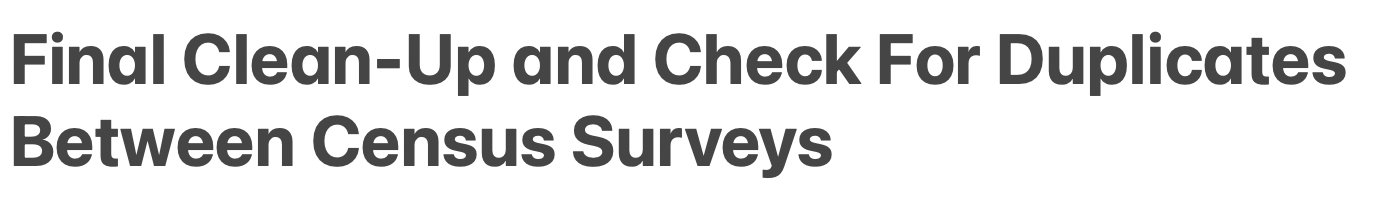

In [77]:
# duplicated columns between datsets
columns_to_delete = [
    'HOUSING OCCUPANCY - Total housing units',
    'PLACE OF BIRTH - Total population',
    'EMPLOYMENT STATUS - Population 16 years and over',
    'HOUSING OCCUPANCY - Occupied housing units',
    'COMPUTERS AND INTERNET USE - Total households',
    'Population in households - Householder',
    'Population born outside the United States - Native',
    'Total Civilian Noninstitutionalized Population'
]


# deleting the columns
fulldata_pct_df = fulldata_pct_df.drop(columns=columns_to_delete)
fulldata_prf_df = fulldata_prf_df.drop(columns=columns_to_delete)


In [78]:
# Identify numeric columns
numeric_cols_prf = fulldata_prf_df.select_dtypes(include=np.number).columns.tolist()
numeric_cols_pct = fulldata_pct_df.select_dtypes(include=np.number).columns.tolist()

# Replace NaNs in numeric columns with their median
fulldata_prf_df.loc[:, numeric_cols_prf] = fulldata_prf_df.loc[:, numeric_cols_prf].fillna(fulldata_prf_df[numeric_cols_prf].median())
fulldata_pct_df.loc[:, numeric_cols_pct] = fulldata_pct_df.loc[:, numeric_cols_pct].fillna(fulldata_pct_df[numeric_cols_pct].median())


In [79]:
# Replace NaNs in 'Other Votes' with 0
fulldata_prf_df['Other Votes'].fillna(0, inplace=True)
fulldata_pct_df['Other Votes'].fillna(0, inplace=True)

# Find columns with more than 100 NaNs
cols_to_drop_prf = fulldata_prf_df.columns[fulldata_prf_df.isnull().sum() > 100].tolist()
cols_to_drop_pct = fulldata_pct_df.columns[fulldata_pct_df.isnull().sum() > 100].tolist()

# # Exclude 'Other Votes' from the list
cols_to_drop_prf = [col for col in cols_to_drop_prf if col != 'Other Votes']
cols_to_drop_pct = [col for col in cols_to_drop_pct if col != 'Other Votes']
# cols_to_drop_prf = [col for col in cols_to_drop_prf]
# cols_to_drop_pct = [col for col in cols_to_drop_pct]

# Drop these columns
fulldata_prf_df.drop(columns=cols_to_drop_prf, inplace=True)
fulldata_pct_df.drop(columns=cols_to_drop_pct, inplace=True)

# For 'RACE - ...' and 'LANGUAGE SPOKEN AT HOME...' categories, replace NaNs with 0
race_language_cols_prf = [col for col in fulldata_prf_df if 'RACE -' in col or 'LANGUAGE SPOKEN AT HOME' in col]
race_language_cols_pct = [col for col in fulldata_pct_df if 'RACE -' in col or 'LANGUAGE SPOKEN AT HOME' in col]

fulldata_prf_df[race_language_cols_prf] = fulldata_prf_df[race_language_cols_prf].fillna(0)
fulldata_pct_df[race_language_cols_pct] = fulldata_pct_df[race_language_cols_pct].fillna(0)

# For the remaining numeric columns, replace NaNs with the column's median
fulldata_prf_df.loc[:, numeric_cols_prf] = fulldata_prf_df.loc[:, numeric_cols_prf].fillna(fulldata_prf_df[numeric_cols_prf].median())
fulldata_pct_df.loc[:, numeric_cols_pct] = fulldata_pct_df.loc[:, numeric_cols_pct].fillna(fulldata_pct_df[numeric_cols_pct].median())



In [80]:
fulldata_pct_df.shape

(435, 466)

In [81]:
fulldata_prf_df.shape

(435, 466)

# Add on State PVI info

In [82]:
# Load the data
state_pvi_df = pd.read_csv('data/2022 State PVI.csv')

# Convert %'s to numeric
# Remove the "%" character and convert to numeric type
for col in ["2020 Biden %", "2020 Trump %", "2016 Clinton %", "2016 Trump %"]:
    state_pvi_df[col] = state_pvi_df[col].str.replace("%", "").astype(float)
    
# Create new column for the state overall 2020 and 2016 performance
state_pvi_df["2020 State Diff"] = state_pvi_df["2020 Biden %"] - state_pvi_df["2020 Trump %"]
state_pvi_df["2016 State Diff"] = state_pvi_df["2016 Clinton %"] - state_pvi_df["2016 Trump %"]

# Convert state pvi with convert_pvi function
state_pvi_df['2022 State PVI'] = state_pvi_df['2022 State PVI'].apply(convert_pvi)

state_pvi_df.head()

,State,2022 State PVI,2020 Biden %,2020 Trump %,2016 Clinton %,2016 Trump %,National 2020 Pres Popular %,National 2022 House Popular %,2020 State Diff,2016 State Diff
0,Alabama,-15.0,36.6,62.0,34.4,62.1,4.539,-2.183,-25.4,-27.7
1,Alaska,-8.0,42.8,52.8,36.6,51.3,4.539,-2.183,-10.0,-14.7
2,Arizona,-2.0,49.4,49.1,44.6,48.1,4.539,-2.183,0.3,-3.5
3,Arkansas,-16.0,34.8,62.4,33.7,60.6,4.539,-2.183,-27.6,-26.9
4,California,13.0,63.5,34.3,61.7,31.6,4.539,-2.183,29.2,30.1


In [83]:
# Invert my states dictionary
state_mapping = {v: k for k, v in states.items()}

# Extract the state abbreviation and map it to the full state name
fulldata_pct_df['State'] = fulldata_pct_df['Formatted_District'].str.split('-').str[0].map(state_mapping)
fulldata_prf_df['State'] = fulldata_prf_df['Formatted_District'].str.split('-').str[0].map(state_mapping)

# Merge the two dataframes
fulldata_pct_df = pd.merge(fulldata_pct_df, state_pvi_df, on='State', how='left')
fulldata_prf_df = pd.merge(fulldata_prf_df, state_pvi_df, on='State', how='left')


In [94]:
drop_merge_cols = ['State']

fulldata_pct_df = fulldata_pct_df.drop(columns = drop_merge_cols)
fulldata_prf_df = fulldata_prf_df.drop(columns = drop_merge_cols)

In [95]:
fulldata_pct_df.to_csv('data/Full_Dataset_PCT.csv')
fulldata_prf_df.to_csv('data/Full_Dataset_PRF.csv')